In [1]:
import networkx as nx
import numpy as np
import faiss
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [2]:
# load the embedding csv files
# H_1 = pd.load_csv(input="/home/dsi/orrbavly/GNN_project/embeddings/new_embeddings/romi_embeddings/1_A_B_H.csv")
# OC_1 = pd.load_csv(input="/home/dsi/orrbavly/GNN_project/embeddings/new_embeddings/romi_embeddings/1_A_B_OC.csv")

## Create Graphs

In [2]:
def filter_adjacency_matrix(adjacency_matrix, threshold):
    """
    Filters an adjacency matrix by setting values below a threshold to zero.
    Parameters:
    - adjacency_matrix (np.ndarray): The original adjacency matrix.
    - threshold (float): The threshold value. Only values greater than this threshold will be kept.
    Returns:
    - filtered_matrix (np.ndarray): The filtered adjacency matrix.
    """
    # Copy the original adjacency matrix to avoid modifying it
    filtered_matrix = np.copy(adjacency_matrix)
    # Apply the threshold filter
    filtered_matrix[filtered_matrix < threshold] = 0
    
    return filtered_matrix

# run faiss to create adjencency matrix
def creating_percentiles(file_path):
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k, distance_metric = 'cosine'):
        if distance_metric == 'cosine':
            # Normalize the embeddings
            embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
            # When embeddings are normalized, the inner product is equivalent to cosine similarity. 
            index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product(IP) for cosine similarity
        elif distance_metric == 'euclidean':
            # should not normelize beforeahand, or it will distort their original magnitudes
            index = faiss.IndexFlatL2(embeddings.shape[1])  # Using L2 distance (Euclidean)
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k, threshold=None):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

    # Define different k values to explore
    N = embeddings.shape[0]
    k_value = int(np.sqrt(N))
    percentiles = [25, 50, 75, 90, 95, 99]
    # Threshold:

    distances, indices = create_faiss_index(embeddings, k_value, distance_metric="cosine")
    adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k_value)
    
    distances_flat = adjacency_matrix.flatten()
    distances_flat = distances_flat[distances_flat > 0]
    calculated_percentiles = np.percentile(distances_flat, percentiles)
    # Print the percentiles for each k value
    print(f"Percentiles of Distances for k={k_value}: {calculated_percentiles}")

    ## AFTER calculating the percentiles, create a new Adjecency matrix, filtered bases on given THRESHOLD

    # Select a threshold based on a desired percentile (e.g., 90th percentile)
    threshold = calculated_percentiles[3]  # 90th percentile
    filtered_adjacency_matrix = filter_adjacency_matrix(adjacency_matrix, threshold)

    # Creare networkx Graph containing the embeddings
    G = nx.from_numpy_array(filtered_adjacency_matrix)
    # add node features (embeddings) to graph
    for i, embedding in enumerate(embeddings):
        G.nodes[i]['embedding'] = embedding

    return filtered_adjacency_matrix, G


In [6]:
def analyze_graph(adjacency_matrix):
    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)

    # Number of edges
    num_edges = G.number_of_edges()
    
    # Number of connected components
    num_connected_components = nx.number_connected_components(G)
    
    # Node degrees
    degrees = [degree for node, degree in G.degree()]
    average_degree = np.mean(degrees)
    degree_distribution = np.histogram(degrees, bins=range(1, max(degrees) + 2))

    print(f"Number of Nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {num_edges}")
    print(f"Number of connected components: {num_connected_components}")
    print(f"Average node degree: {average_degree}")
    print("Degree distribution (degree: count):")
    i = 0
    for degree, count in zip(degree_distribution[1][:-1], degree_distribution[0]):
        print(f"Degree {degree}: {count}")
        i += 1
        if (i == 10):
            break

    nx.draw(G, with_labels=False, node_size=10)
    plt.show()

In [7]:
ad_H1, H1_g = creating_percentiles("/home/dsi/orrbavly/GNN_project/embeddings/new_embeddings/romi_embeddings/1_A_B_H.csv")
ad_OC1, OC1_g = creating_percentiles("/home/dsi/orrbavly/GNN_project/embeddings/new_embeddings/romi_embeddings/1_A_B_OC.csv")

Percentiles of Distances for k=116: [0.71321595 0.74498403 0.77925032 0.82414031 0.85705941 0.9089472 ]
Percentiles of Distances for k=93: [0.70573258 0.74008971 0.77781737 0.82761803 0.86070115 0.91139889]


Number of Nodes: 13523
Number of edges: 77763
Number of connected components: 4153
Average node degree: 11.500850403017083
Degree distribution (degree: count):


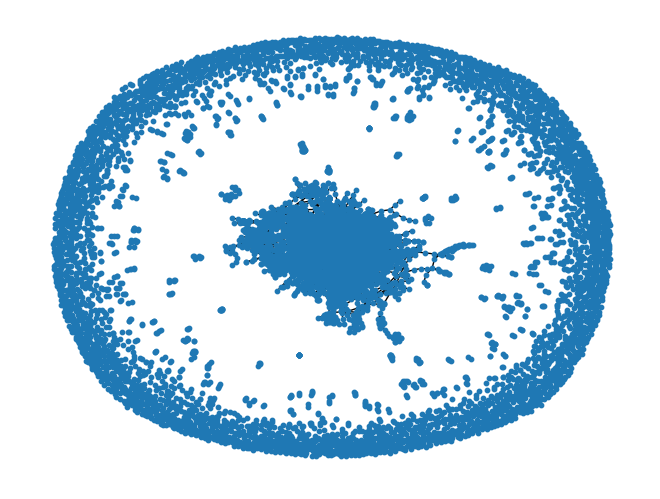

In [ ]:
analyze_graph(ad_H1)

Number of Nodes: 8746
Number of edges: 100719
Number of connected components: 687
Average node degree: 23.032014635261834
Degree distribution (degree: count):


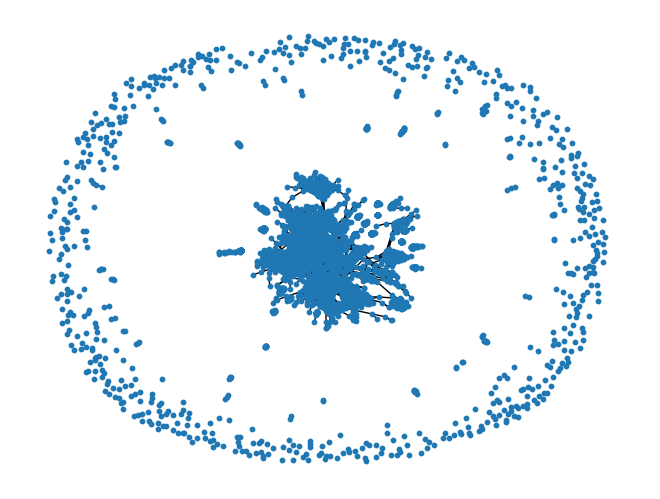

In [14]:
analyze_graph(ad_OC1)

# EDA Graphs

## visualizing graphs

In [7]:
# dl conda
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Function to find files based on patient name
def find_graphs_by_patient_name(root_dir, patient_name):
    graph_files = []
    
    # Walk through the directory and find files with the patient name
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.startswith(f"{patient_name}"):
                subfolder = os.path.basename(dirpath)  # Get the subfolder name
                graph_files.append((subfolder, os.path.join(dirpath, filename)))  # Return subfolder and file path
    
    return graph_files

# Function to load a graph from a pickle file
def load_graph_from_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        graph = pickle.load(f)
    return graph

In [21]:
# Function to calculate and return graph statistics
def get_graph_statistics(G):
    # Number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Number of connected components
    num_connected_components = nx.number_connected_components(G)
    
    # Node degrees
    degrees = [degree for _, degree in G.degree()]
    average_degree = np.mean(degrees)
    
    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "num_connected_components": num_connected_components,
        "average_degree": average_degree,
    }

# Function to visualize multiple graphs side by side with statistics
def visualize_graphs_with_stats(graphs, subfolders, patient_name):
    num_graphs = len(graphs)
    
    # Create subplots side by side
    fig, axes = plt.subplots(1, num_graphs, figsize=(6 * num_graphs, 6))  # Adjust figure size if necessary
    
    print("Starting to visualize graphs...")
    for i, graph in enumerate(graphs):
        ax = axes[i] if num_graphs > 1 else axes  # Handle case where there's only 1 graph
        
        print(f"drwaing graph number {i + 1}")
        # Draw the graph on the axes
        nx.draw(graph, ax=ax, with_labels=False, node_size=10, node_color='skyblue', edge_color='gray')
        
        # Calculate statistics for the graph
        stats = get_graph_statistics(graph)
        
        threshold = subfolders[i].split('_')[2] ## takes the percentile from subfolder name for later visualization.

        # Display graph statistics
        stats_text = (
            f"Folder: {threshold}\n"  
            f"Nodes: {stats['num_nodes']}\n"
            f"Edges: {stats['num_edges']}\n"
            f"Components: {stats['num_connected_components']}\n"
            f"Avg Degree: {stats['average_degree']:.2f}\n"
        )
        
        # Add text with graph statistics on the plot
        ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
        
        ax.set_title(f"Graph {i+1} ({patient_name}_{threshold})")
    
    plt.tight_layout()
    plt.show()

In [12]:
# Main function to search, load, and visualize graphs
def run_eda(patient_name, root_dir):
    # Find graph files for the given patient name
    graph_files = find_graphs_by_patient_name(root_dir, patient_name)
    
    # Load the graphs and get the corresponding subfolder names
    graphs = [load_graph_from_pickle(f[1]) for f in graph_files]
    subfolders = [f[0] for f in graph_files]  # Extract subfolder names
    
    # Visualize the graphs side by side with statistics and subfolder info
    visualize_graphs_with_stats(graphs, subfolders, patient_name)


Starting to visualize graphs...
drwaing graph number 1
drwaing graph number 2
drwaing graph number 3
drwaing graph number 4


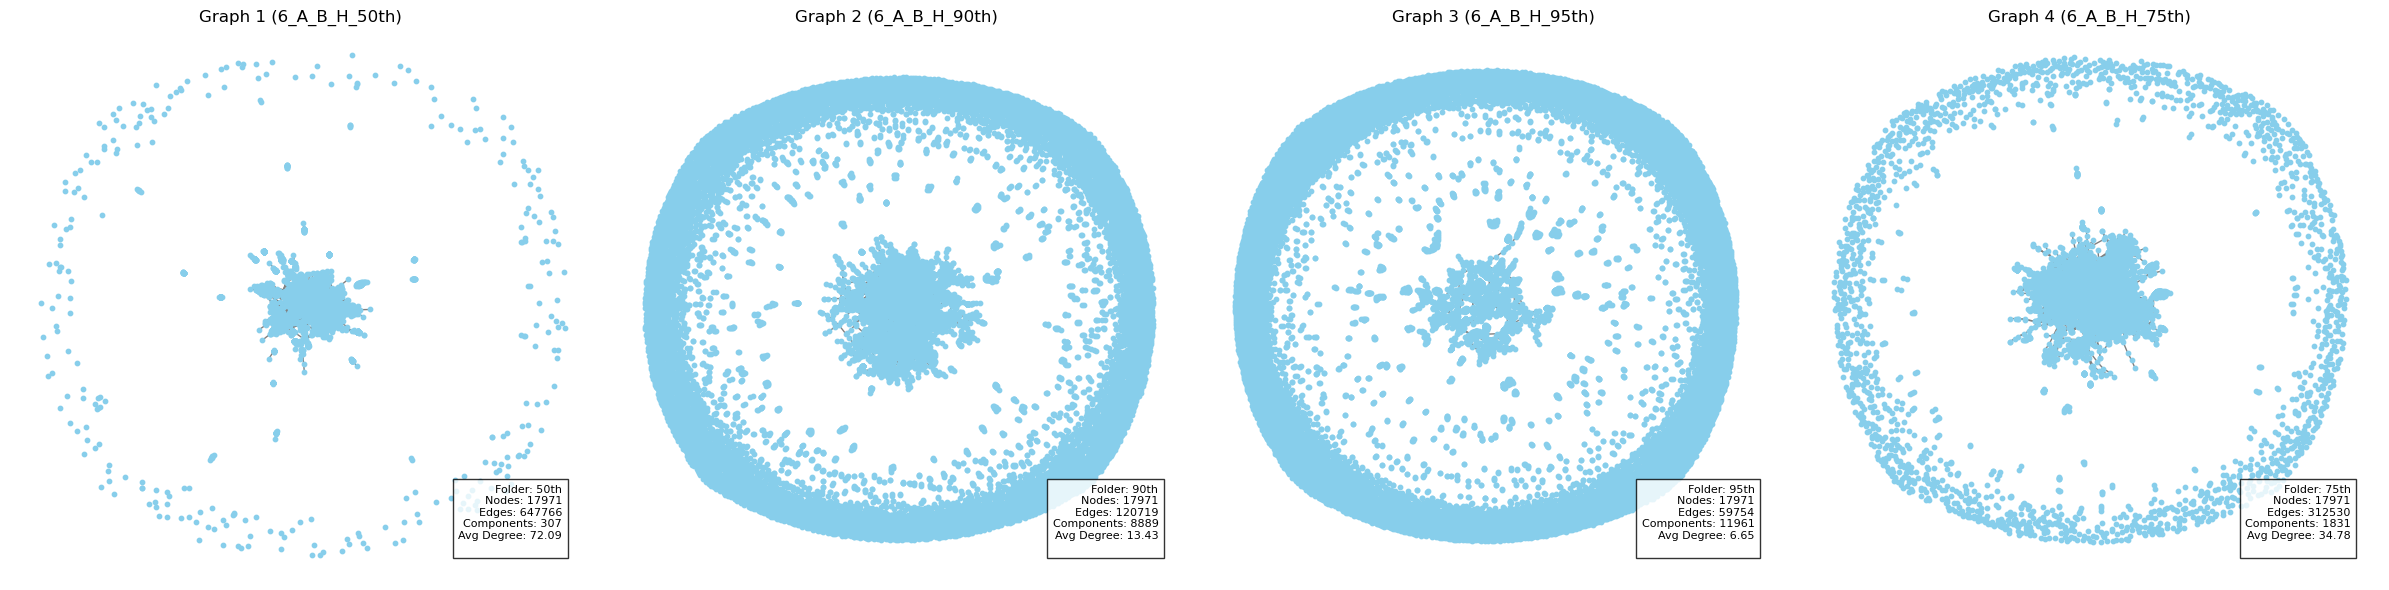

In [22]:
root_directory = '/home/dsi/orrbavly/GNN_project/data'  # Root directory where the folders are located
patient_name = '6_A_B_H'  # patient name we're searching for

run_eda(patient_name, root_directory)

Starting to visualize graphs...
drwaing graph number 1
drwaing graph number 2
drwaing graph number 3
drwaing graph number 4


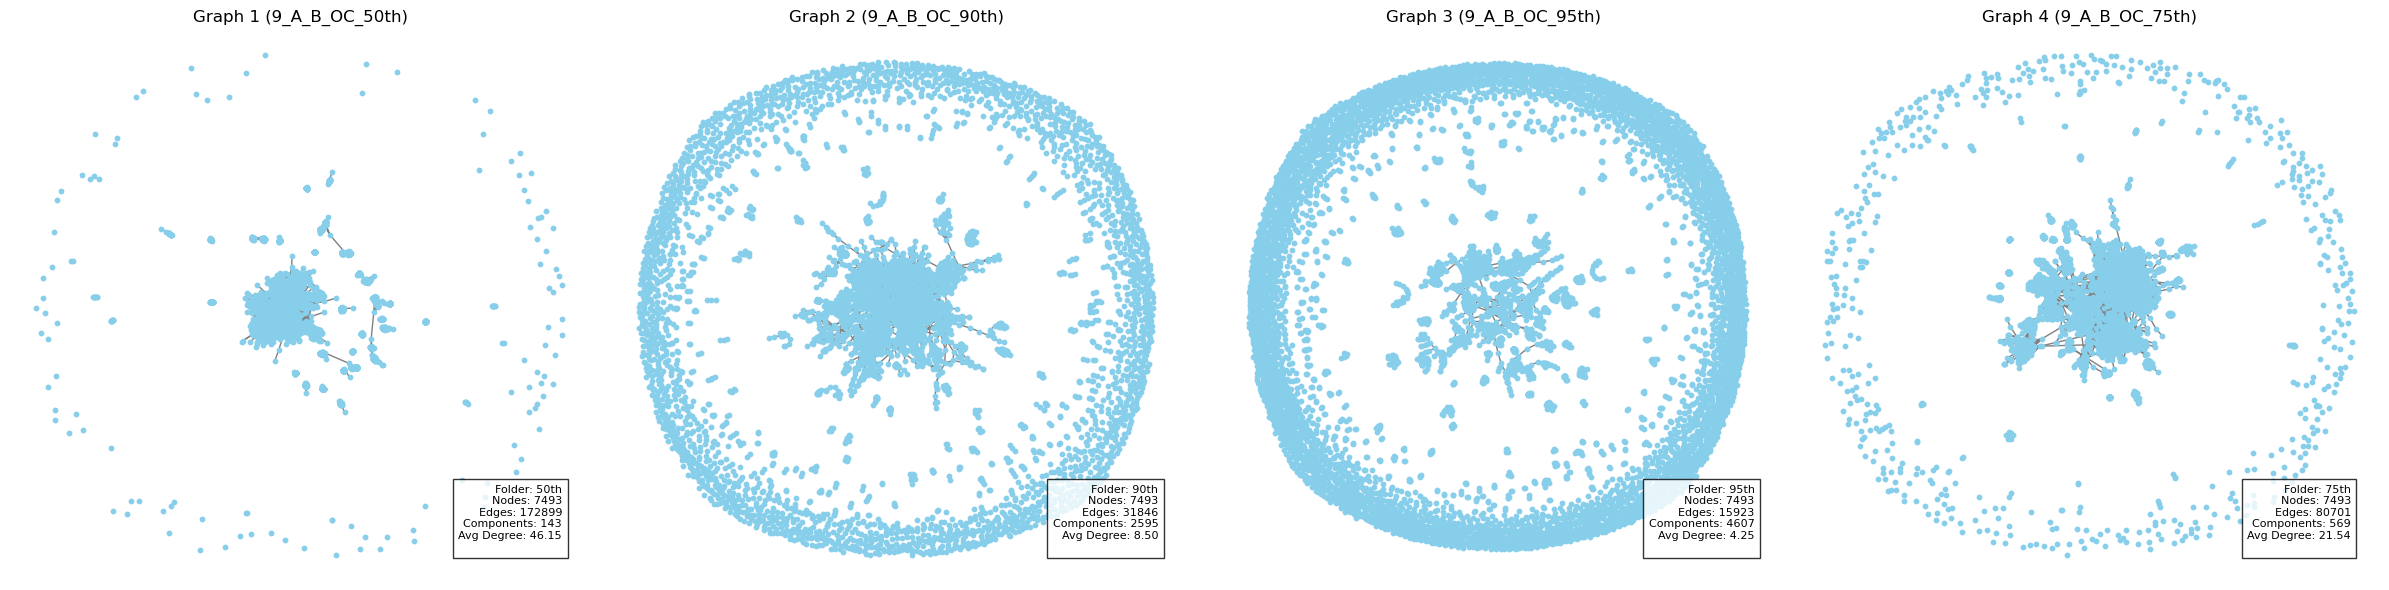

In [23]:
# Example usage:
root_directory = '/home/dsi/orrbavly/GNN_project/data'  # Root directory where the folders are located
patient_name = '9_A_B_OC'  # Replace with the patient name you're searching for

run_eda(patient_name, root_directory)

In [2]:
# Function to create a CSV file with source and target columns from a NetworkX graph
def save_graph_to_csv(graph, filename):
    # Extract edges from the graph
    edges = list(graph.edges())

    # Convert the edges to a DataFrame
    df = pd.DataFrame(edges, columns=['source', 'target'])

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)

In [6]:
root_directory = '/home/dsi/orrbavly/GNN_project/data'  # Root directory where the folders are located
patient_name = '6_A_B_H'  # patient name we're searching for

graph_files = find_graphs_by_patient_name(root_directory, patient_name)

graphs = [load_graph_from_pickle(f[1]) for f in graph_files]
subfolders = [f[0] for f in graph_files]

In [9]:
for graph, subfolder in zip(graphs, subfolders):
    save_graph_to_csv(graph, f"/home/dsi/orrbavly/GNN_project/data/cosmos_csv/{patient_name}_{subfolder}")

## targeting specific TCRs

In [1]:
import os
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
all_data = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/data_ab_83.csv")

In [3]:
tcr_sequences = ['CAVRDSNYQLIW', 'CVVSDRGSTLGRLYF', 'CAVLDSNYQLIW', 'CASSLGETQYF']


In [4]:
# Assuming `all_data` is your DataFrame and the first column is the patient name
# Columns of interest are the TCR sequences provided in the `tcr_sequences` list

# Filter columns that match TCR sequences
tcr_columns = [col for col in tcr_sequences if col in all_data.columns]

# Check which rows have any non-zero value in the specified TCR columns
filtered_rows = all_data[(all_data[tcr_columns] != 0).any(axis=1)]

# Print only the patient names from the 'Unnamed: 0' column
print(filtered_rows['Unnamed: 0'])


0       1_A_B_H
1      1_A_B_OC
2      10_A_B_H
3     10_A_B_OC
4      11_A_B_H
        ...    
78      7_A_B_H
79     7_A_B_OC
80      8_A_B_H
81      9_A_B_H
82     9_A_B_OC
Name: Unnamed: 0, Length: 79, dtype: object


In [5]:
# Filter columns that match TCR sequences
tcr_columns = [col for col in tcr_sequences if col in all_data.columns]

# Check which rows have non-zero values for all specified TCR columns
filtered_rows = all_data[(all_data[tcr_columns] != 0).all(axis=1)]

# Print only the patient names from the 'Unnamed: 0' column
print(filtered_rows['Unnamed: 0'])

1      1_A_B_OC
20     19_A_B_H
27     22_A_B_H
29     23_A_B_H
37     28_A_B_H
38    28_A_B_OC
43     30_A_B_H
45     32_A_B_H
49     35_A_B_H
52     37_A_B_H
62     41_A_B_H
64     42_A_B_H
65     43_A_B_H
66     44_A_B_H
67     45_A_B_H
69     46_A_B_H
70     47_A_B_H
75     51_A_B_H
Name: Unnamed: 0, dtype: object


In [12]:
import os
import pandas as pd
# Define the list of TCR sequences you are looking for
tcr_sequences = ['CAVRDSNYQLIW', 'CVVSDRGSTLGRLYF', 'CAVLDSNYQLIW', 'CASSLGETQYF']

# Specify the directory containing the CSV files
directory_path = '/home/dsi/orrbavly/GNN_project/embeddings/new_embeddings/csvs' 
# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    # Check if the file is a CSV file
    if 'fp' not in filename and 'nd' not in filename and 'nh' not in filename:
        # print(f"working on file: {filename}")
        file_path = os.path.join(directory_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Count how many of the TCR sequences are present in the file
        count_present = sum(seq in df.values for seq in tcr_sequences)
        
        # Print the result for each file
        # print(f"File: {filename} - Number of TCR sequences found: {count_present}")
        
        # Get the number of rows
        num_rows = df.shape[0]

        # Print the number of rows
        print(f"Number of rows in the {filename} file: {num_rows}")

Number of rows in the 23_A_B_H.csv file: 16868
Number of rows in the 27_A_B_H.csv file: 17558
Number of rows in the 6_A_B_H.csv file: 17971
Number of rows in the 19_A_B_OC.csv file: 19548
Number of rows in the 45_A_B_OC.csv file: 15569
Number of rows in the 35_A_B_H.csv file: 12168
Number of rows in the 9_A_B_H.csv file: 18119
Number of rows in the 10_A_B_H.csv file: 16067
Number of rows in the 17_A_B_H.csv file: 18766
Number of rows in the 14_A_B_OC.csv file: 14978
Number of rows in the 24_A_B_H.csv file: 14673
Number of rows in the 34_A_B_H.csv file: 11023
Number of rows in the 1_A_B_H.csv file: 13523
Number of rows in the 37_A_B_OC.csv file: 16087
Number of rows in the 5_A_B_H.csv file: 17544
Number of rows in the 39_A_B_OC.csv file: 15926
Number of rows in the 20_A_B_OC.csv file: 12869
Number of rows in the 38_A_B_OC.csv file: 15808
Number of rows in the 21_A_B_OC.csv file: 18335
Number of rows in the 20_A_B_H.csv file: 16886
Number of rows in the 29_A_B_OC.csv file: 13543
Number o

In [2]:
# Function to load all NetworkX graphs from a given directory
def load_graphs_from_dir(directory_path):
    graphs = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if 'fp' not in filename:
            file_path = os.path.join(directory_path, filename)
            base_filename = os.path.splitext(filename)[0]
            # Load the NetworkX graph from the pickle file
            with open(file_path, 'rb') as f:
                graph = pickle.load(f)
                if isinstance(graph, nx.Graph):
                    graphs.append((graph, base_filename))
                else:
                    print(f"File {filename} does not contain a valid NetworkX graph.")
    
    return graphs   

In [7]:
graphs = load_graphs_from_dir('/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc_new')
tcr_sequences = ['CAVRDSNYQLIW', 'CVVSDRGSTLGRLYF', 'CAVLDSNYQLIW', 'CASSLGETQYF']

In [4]:
import itertools

In [9]:
for graph, graph_name in graphs:
    if 'fp' not in graph_name:
        # Count how many of the TCR sequences are present in the graph's nodes
        count_present = sum(seq in graph.nodes for seq in tcr_sequences)
        
        # Print the graph name and the count of TCR sequences found
        print(f"Graph: {graph_name} - Number of TCR sequences found: {count_present}")
        # print(f"Graph: {graph_name} - has {graph.number_of_nodes()} nodes")
        # Check for the first 10 nodes and their neighbors
        # for node in itertools.islice(graph.nodes, 10):
        #     print(f"Node: {node}")
            
        #     # Check the edges connected to this node
        #     for neighbor in graph.neighbors(node):
        #         # Check if there is a weight attribute between the node and its neighbor
        #         edge_data = graph.get_edge_data(node, neighbor)
        #         if 'weight' in edge_data:
        #             print(f"Edge between {node} and {neighbor} has weight: {edge_data['weight']}")
        #         else:
        #             print(f"Edge between {node} and {neighbor} has no weight attribute.")
        
        # break  # Break after processing the first graph


Graph: 3_A_B_OC - Number of TCR sequences found: 1
Graph: 7_nd_A_B_H - Number of TCR sequences found: 1
Graph: 38_A_B_H - Number of TCR sequences found: 3
Graph: 14_nd_A_B_H - Number of TCR sequences found: 1
Graph: 32_A_B_OC - Number of TCR sequences found: 2
Graph: 1_A_B_OC - Number of TCR sequences found: 3
Graph: 13_nd_A_B_OC - Number of TCR sequences found: 1
Graph: 10_nd_A_B_OC - Number of TCR sequences found: 3
Graph: 7_nh_A_B_H - Number of TCR sequences found: 1
Graph: 40_A_B_H - Number of TCR sequences found: 3
Graph: 37_A_B_H - Number of TCR sequences found: 4
Graph: 11_nd_A_B_H - Number of TCR sequences found: 2
Graph: 43_A_B_H - Number of TCR sequences found: 4
Graph: 18_nd_A_B_H - Number of TCR sequences found: 0
Graph: 14_A_B_OC - Number of TCR sequences found: 1
Graph: 10_A_B_OC - Number of TCR sequences found: 2
Graph: 11_nh_A_B_H - Number of TCR sequences found: 2
Graph: 2_A_B_H - Number of TCR sequences found: 1
Graph: 7_nd_A_B_OC - Number of TCR sequences found: 2
Gr

## EDA on selected TCRs

In [2]:
# Function to load all NetworkX graphs from a given directory
def load_graphs_from_dir(directory_path):
    graphs = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if 'fp' not in filename:
            file_path = os.path.join(directory_path, filename)
            base_filename = os.path.splitext(filename)[0]
            # Load the NetworkX graph from the pickle file
            with open(file_path, 'rb') as f:
                graph = pickle.load(f)
                if isinstance(graph, nx.Graph):
                    graphs.append((graph, base_filename))
                else:
                    print(f"File {filename} does not contain a valid NetworkX graph.")
    
    return graphs   

1. Eigenvector centrality assigns importance to a node based not only on its connections but also on the importance of its neighbors. Nodes that are connected to highly central nodes are themselves considered more important.
2. PageRank is similar to eigenvector centrality but was designed by Google to rank web pages. It accounts for both the number and the quality of the links pointing to a node. It provides a probabilistic measure of importance by simulating random walks on the graph.
3. Katz centrality is similar to eigenvector centrality but adds a constant to nodes with fewer connections, allowing for the inclusion of even less-connected nodes. It measures the relative influence of a node within a network by considering the number of walks that connect it to other nodes.
4. HITS is an algorithm that divides nodes into two categories:
- Hub: A node that points to many other nodes (or TCR sequences).
- Authority: A node that is pointed to by many hubs.
This is particularly useful when you want to differentiate between sequences that connect to others (hubs) and those that are referenced by hubs (authorities).
5. The core number of a node is the largest value k such that the node belongs to the k-core of the graph. The k-core is a subgraph where each node has at least k neighbors. This measure is useful for identifying tightly-knit groups of nodes.
6. The clustering coefficient measures how close a node’s neighbors are to being a complete clique (i.e., fully connected). Nodes with high clustering coefficients are part of highly interconnected communities.
7. Assortativity Coefficient (Node Connectivity) measures the tendency of nodes to connect to other nodes with similar degrees (i.e., are high-degree nodes connecting to other high-degree nodes?).
8. Structural Holes (Brokerage and Constraint): Nodes that bridge structural holes (gaps between different parts of the network) are considered important for connecting disparate parts of the network. The constraint metric captures the extent to which a node is constrained by its neighbors.



In [23]:
# Function to accumulate centrality information and store results in a Pandas DataFrame
def accumulate_tcr_centrality_to_df(graphs_with_names, tcr_sequences):
    # graphs_with_names: list of tuples in format (graph, graph_name)
    results = []

    # Iterate through each graph
    # Iterate through each graph and its corresponding name from the tuple
    for graph, graph_name in graphs_with_names:
        print(f"working on graph: {graph_name}")
        # Calculate centrality and other importance measures for the graph
        print("Degree")
        degree_centrality = nx.degree_centrality(graph)
        print("betweenes")
        # Using approximation for betweenness centrality to speed up computation
        betweenness_centrality = nx.betweenness_centrality(graph, k=1000)  # Approximate with 100 random nodes
        print("closeness")
        closeness_centrality = nx.closeness_centrality(graph)
        print("eigenvector")
        # Adjusting eigenvector centrality to handle convergence issues with approximation
        try:
            # Try with initial parameters; these might converge close enough without being perfect
            eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500, tol=1e-5)
        except nx.PowerIterationFailedConvergence:
            print(f"Eigenvector centrality failed to converge with default settings for graph: {graph_name}")
            try:
                # If the first attempt fails, retry with looser tolerance for faster convergence
                eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=300, tol=1e-2)
                print(f"Eigenvector centrality approximated for graph: {graph_name} with higher tolerance.")
            except nx.PowerIterationFailedConvergence:
                # If it still fails, fallback to an empty result or a different measure
                eigenvector_centrality = {}
                print(f"Eigenvector centrality could not be approximated for graph: {graph_name}")
        print("pagerank")
        pagerank = nx.pagerank(graph, max_iter=500, tol=1e-6)  # Adjusted max_iter and tol for better convergence
        print("clustering")
        clustering_coefficient = nx.clustering(graph)
        # print("structural")
        # # Calculating structural holes constraint
        # structural_holes_constraint = nx.constraint(graph)

        print("norm")
        # Calculate average centrality values for all nodes as the "norm"
        all_nodes = list(graph.nodes())
        
        # Collect values for each centrality measure
        norm_degree = np.mean([degree_centrality[node] for node in all_nodes])
        norm_betweenness = np.mean([betweenness_centrality[node] for node in all_nodes])
        norm_closeness = np.mean([closeness_centrality[node] for node in all_nodes])
        norm_eigenvector = np.mean([eigenvector_centrality.get(node, 0) for node in all_nodes])
        norm_pagerank = np.mean([pagerank[node] for node in all_nodes])
        norm_clustering = np.mean([clustering_coefficient[node] for node in all_nodes])
        # norm_constraint = np.mean([structural_holes_constraint.get(node, 0) for node in all_nodes])


        # Check for each TCR sequence in the graph
        for tcr in tcr_sequences:
            print(f"working on tcr: {tcr}")
            if tcr in graph:
                # Get individual centrality metrics safely using `.get()`
                degree = degree_centrality.get(tcr, 0)
                betweenness = betweenness_centrality.get(tcr, 0)
                closeness = closeness_centrality.get(tcr, 0)
                eigenvector = eigenvector_centrality.get(tcr, 0)
                page_rank = pagerank.get(tcr, 0)
                clustering = clustering_coefficient.get(tcr, 0)
                # constraint = structural_holes_constraint.get(tcr, 0)
                
                # Add the centrality metrics to the results list
                results.append({
                    'graph_name': graph_name,
                    'tcr_sequence': tcr,
                    'degree_centrality': degree,
                    'betweenness_centrality': betweenness,
                    'closeness_centrality': closeness,
                    'eigenvector_centrality': eigenvector,
                    'pagerank': page_rank,
                    'clustering_coefficient': clustering,
                    # 'constraint': constraint,
                })
            else:
                print(f"TCR {tcr} not found in graph {graph_name}.")
                # If the TCR sequence is not present in the graph, add a row with NaN values
                results.append({
                    'graph_name': graph_name,
                    'tcr_sequence': tcr,
                    'degree_centrality': None,
                    'betweenness_centrality': None,
                    'closeness_centrality': None,
                    'eigenvector_centrality': None,
                    'pagerank': None,
                    'clustering_coefficient': None,
                    # 'constraint': None,
                })

    # Convert the results into a DataFrame
    df = pd.DataFrame(results)
    
    return df

In [26]:
graphs = load_graphs_from_dir('/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc_new')


In [4]:
selected_tcrs = ['CAVRDSNYQLIW', 'CVVSDRGSTLGRLYF', 'CAVLDSNYQLIW', 'CASSLGETQYF']

In [ ]:
# Accumulate the centrality information into a DataFrame
centrality_df = accumulate_tcr_centrality_to_df(graphs, selected_tcrs)

In [ ]:
# Save DataFrame to a CSV file
centrality_df.to_csv('/home/dsi/orrbavly/GNN_project/outputs/centrality_results.csv', index=False)

### Analyze EDA

In [13]:
output_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality_results.csv")

In [14]:
selected_tcrs = ['CAVRDSNYQLIW', 'CVVSDRGSTLGRLYF', 'CAVLDSNYQLIW', 'CASSLGETQYF']

In [15]:
selected_group = output_df[output_df['tcr_sequence'].isin(selected_tcrs)]
other_group = output_df[~output_df['tcr_sequence'].isin(selected_tcrs)]

In [16]:
from scipy.stats import mannwhitneyu


In [17]:
def create_plot(selected_group, other_group, centrality_stat,selected_str="Selected TCRs", other_str="Other Nodes"):
    # Extract Degree Centrality stat for both groups
    selected_degrees = selected_group[centrality_stat].dropna()
    other_degrees = other_group[centrality_stat].dropna()

    # Descriptive Statistics
    print(f"{selected_str} {centrality_stat} - Mean:", np.mean(selected_degrees), "Median:", np.median(selected_degrees))
    print(f"{other_str} {centrality_stat} - Mean:", np.mean(other_degrees), "Median:", np.median(other_degrees))

    # Statistical Test: Mann-Whitney U test (non-parametric)
    stat, p_value = mannwhitneyu(selected_degrees, other_degrees, alternative='greater')
    print("Mann-Whitney U Test p-value:", p_value)

    # Create subplots in a single figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Subplot 1: Box Plot
    axs[0].boxplot([selected_degrees, other_degrees], notch=True, patch_artist=True, labels=[f'{selected_str}', f'{other_str}'])
    axs[0].set_title(f'Comparison of {centrality_stat}')
    axs[0].set_ylabel(f'{centrality_stat}')
    axs[0].grid(True)

    # Subplot 2: Violin Plot
    axs[1].violinplot([selected_degrees, other_degrees], showmeans=True, showmedians=True)
    axs[1].set_xticks([1, 2])
    axs[1].set_xticklabels([f'{selected_str}', f'{other_str}'])
    axs[1].set_title(f'Violin Plot of {centrality_stat}')
    axs[1].grid(True)

    # Subplot 3: Histogram/Density Plot
    axs[2].hist(selected_degrees, bins=20, alpha=0.6, label=f'{selected_str}', color='blue', density=True)
    axs[2].hist(other_degrees, bins=20, alpha=0.6, label=f'{other_str}', color='red', density=True)
    axs[2].set_title(f'{centrality_stat} Distribution')
    axs[2].set_xlabel(f'{centrality_stat}')
    axs[2].set_ylabel('Density')
    axs[2].legend()
    axs[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

Selected TCRs degree_centrality - Mean: 0.0017169010755195835 Median: 0.0015676117775354
Other Nodes degree_centrality - Mean: 0.0008312029746977561 Median: 0.0007943034543594
Mann-Whitney U Test p-value: 6.866338488196213e-08


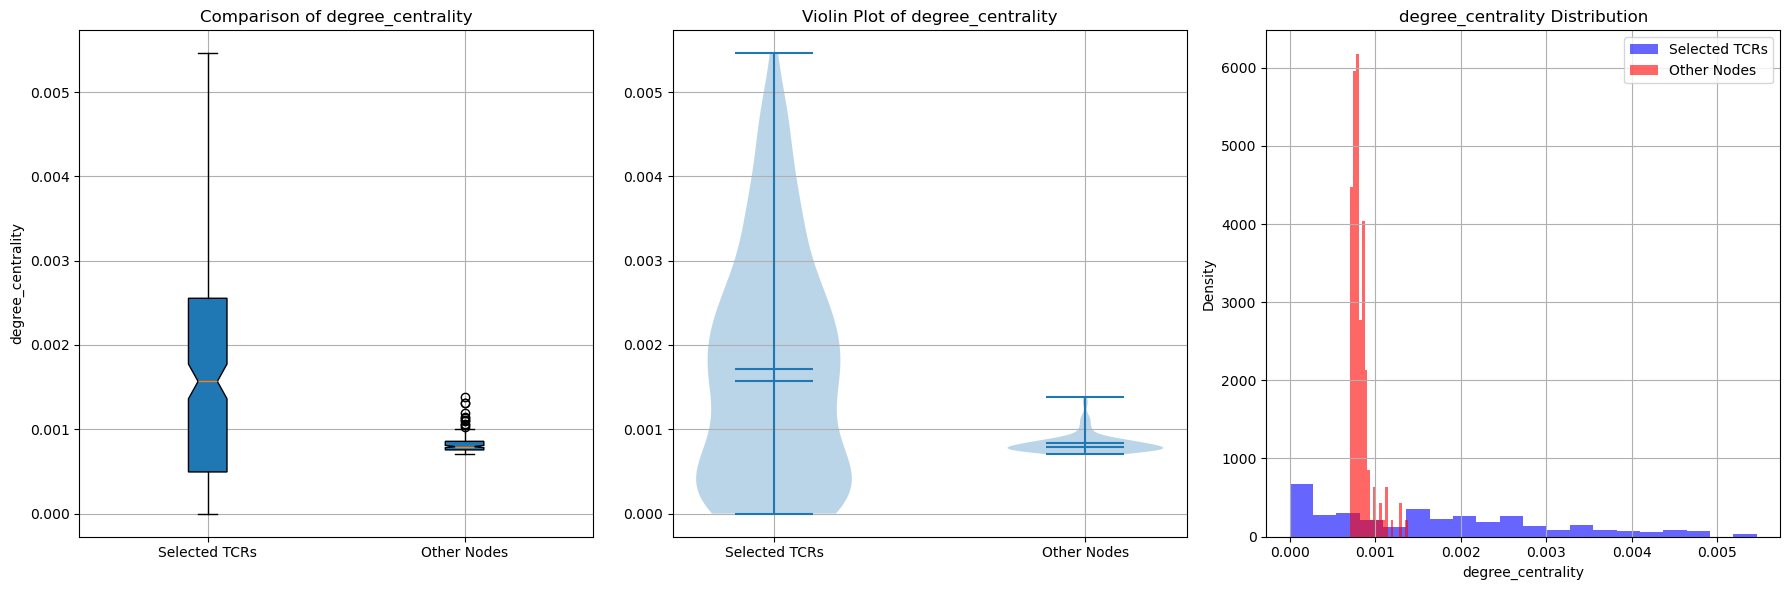

In [18]:
create_plot(selected_group, other_group, centrality_stat='degree_centrality')

Selected TCRs betweenness_centrality - Mean: 0.00045852256268008514 Median: 9.267383664247245e-08
Other Nodes betweenness_centrality - Mean: 3.871244642622629e-05 Median: 9.184501548724316e-06
Mann-Whitney U Test p-value: 0.9999999884760472


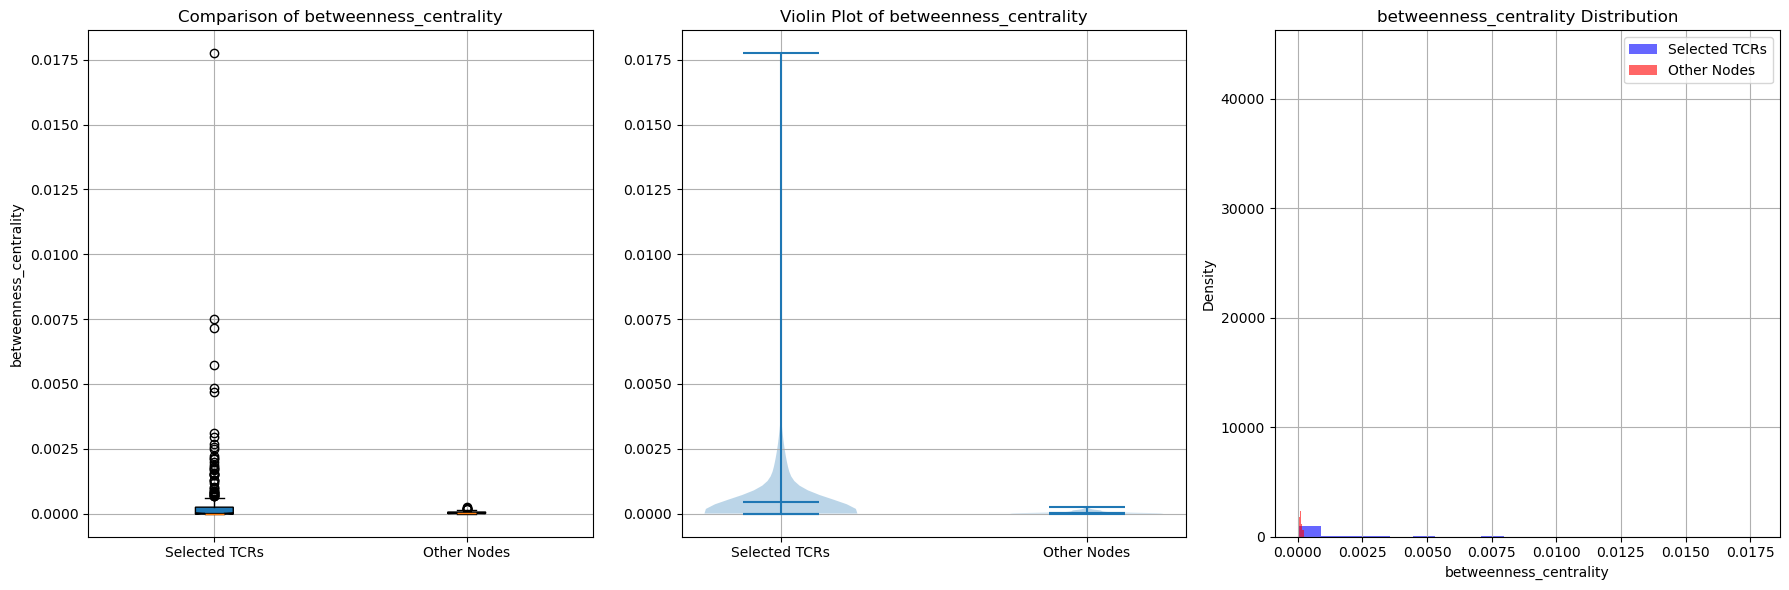

In [19]:
create_plot(selected_group, other_group, centrality_stat='betweenness_centrality')

Selected TCRs closeness_centrality - Mean: 0.009468989645657327 Median: 0.0032884658419724
Other Nodes closeness_centrality - Mean: 0.006956919239335262 Median: 0.0027659655844386
Mann-Whitney U Test p-value: 0.7412469030331807


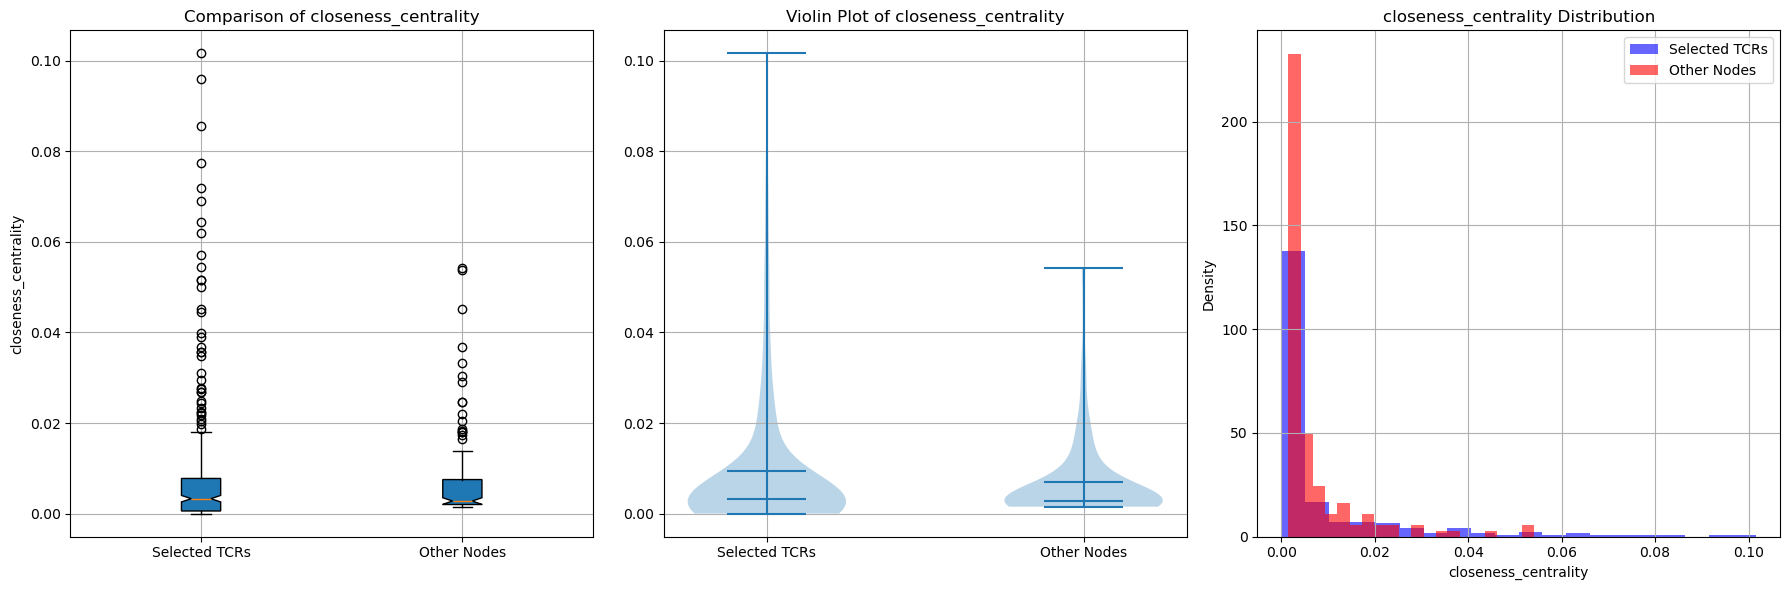

In [20]:
create_plot(selected_group, other_group, centrality_stat='closeness_centrality')

 a node with high eigenvector centrality is connected to other nodes that are themselves influential.

Selected TCRs eigenvector_centrality - Mean: 4.141999841538502e-05 Median: 8.271036540160314e-18
Other Nodes eigenvector_centrality - Mean: 0.0009238295646130347 Median: 0.0008784257966072
Mann-Whitney U Test p-value: 1.0


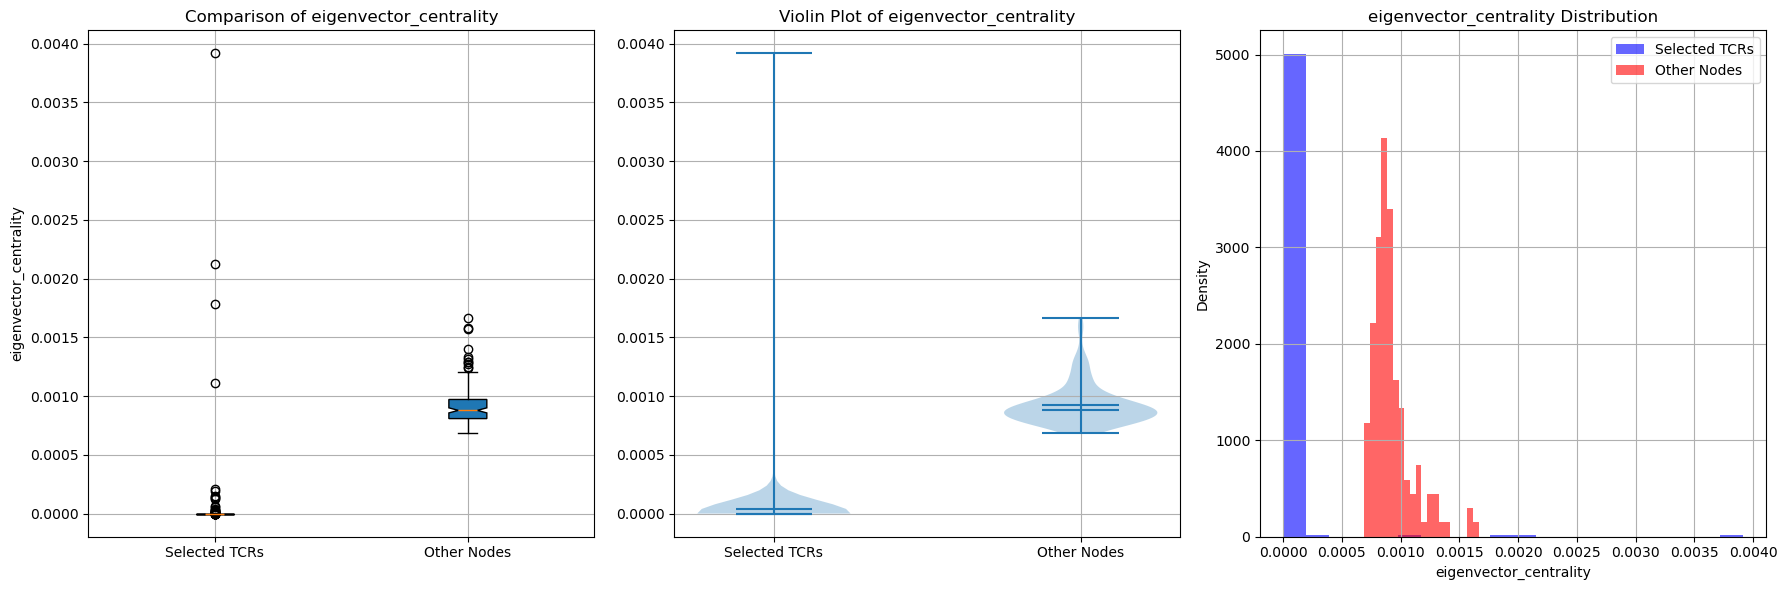

In [21]:
create_plot(selected_group, other_group, centrality_stat='eigenvector_centrality')

A node with a high PageRank is not just connected to many other nodes but is connected to other nodes that are also influential.

Selected TCRs pagerank - Mean: 0.00016524193650132075 Median: 0.0001492563272574
Other Nodes pagerank - Mean: 7.156064337106183e-05 Median: 6.367804381049212e-05
Mann-Whitney U Test p-value: 3.1416969749662815e-38


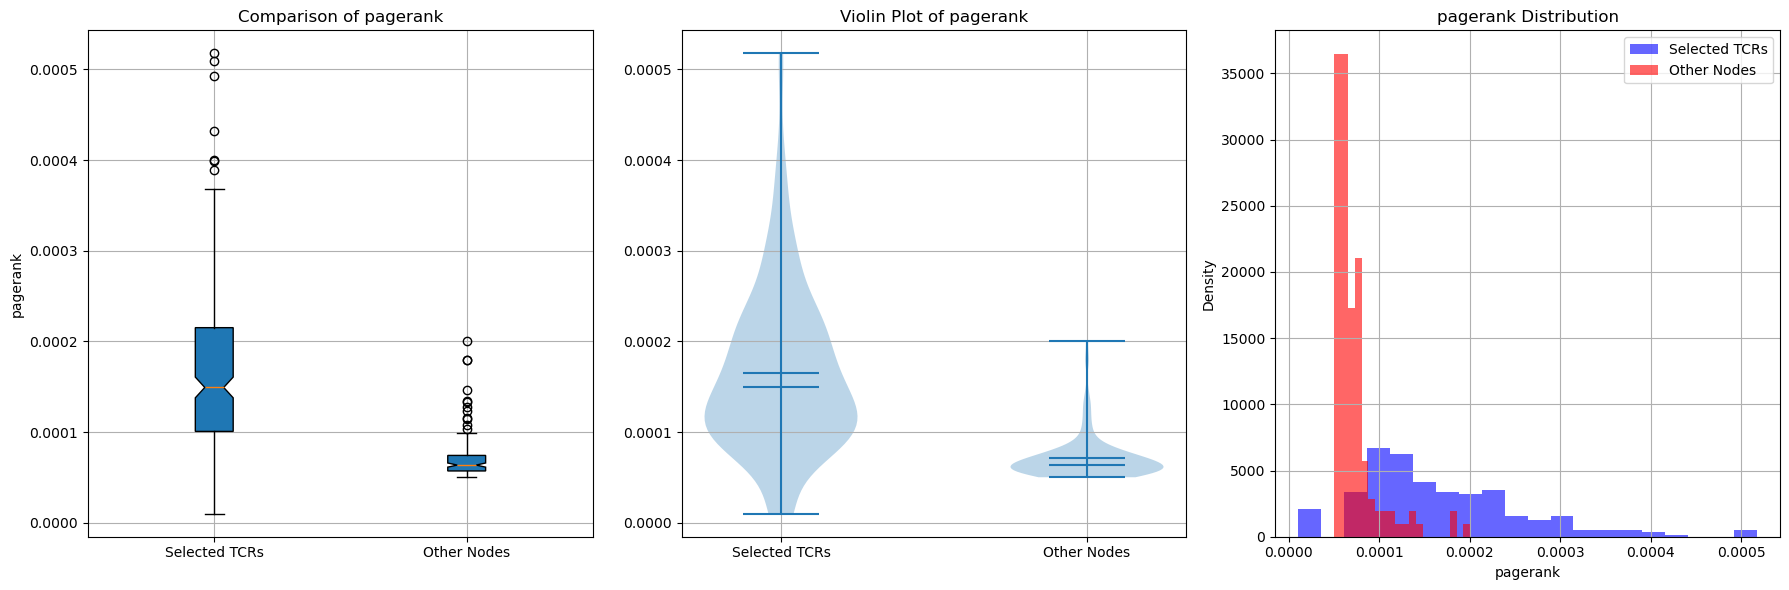

In [22]:
create_plot(selected_group, other_group, centrality_stat='pagerank')

The selected TCR sequences are part of densely connected regions of the network where their neighbors are also highly interconnected.

Selected TCRs clustering_coefficient - Mean: 0.5980937797201066 Median: 0.7753846153846153
Other Nodes clustering_coefficient - Mean: 0.26002407124187665 Median: 0.2616122096693941
Mann-Whitney U Test p-value: 2.033311274950476e-15


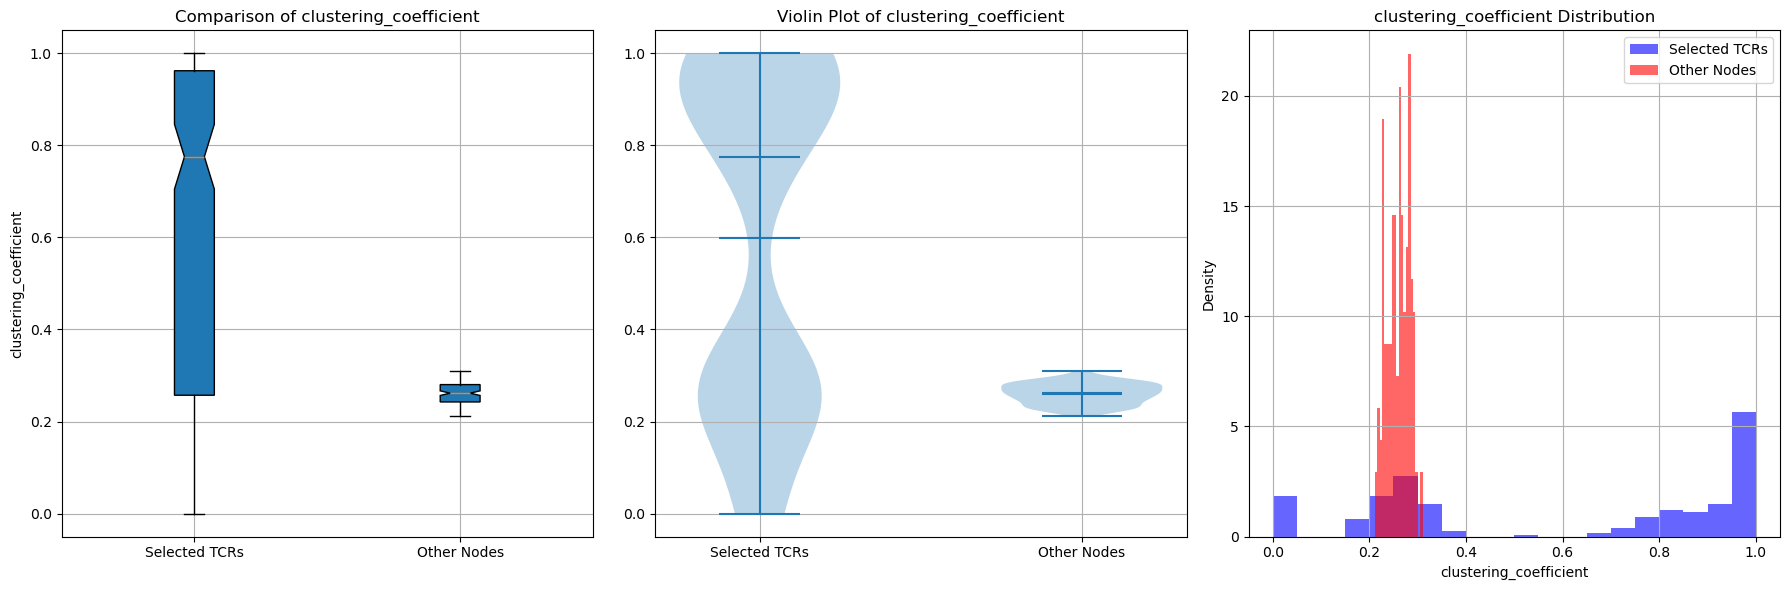

In [23]:
create_plot(selected_group, other_group, centrality_stat='clustering_coefficient')

In [24]:
# Split the selected group into health and OC groups based on the `graph_name` column
selected_h_group = selected_group[selected_group['graph_name'].str.contains('_H')]
selected_oc_group = selected_group[selected_group['graph_name'].str.contains('_OC')]

Healthy patients degree_centrality - Mean: 0.001970460244113276 Median: 0.0018866737941009
Sick patients degree_centrality - Mean: 0.0017169010755195835 Median: 0.0015676117775354
Mann-Whitney U Test p-value: 0.02960517493757416


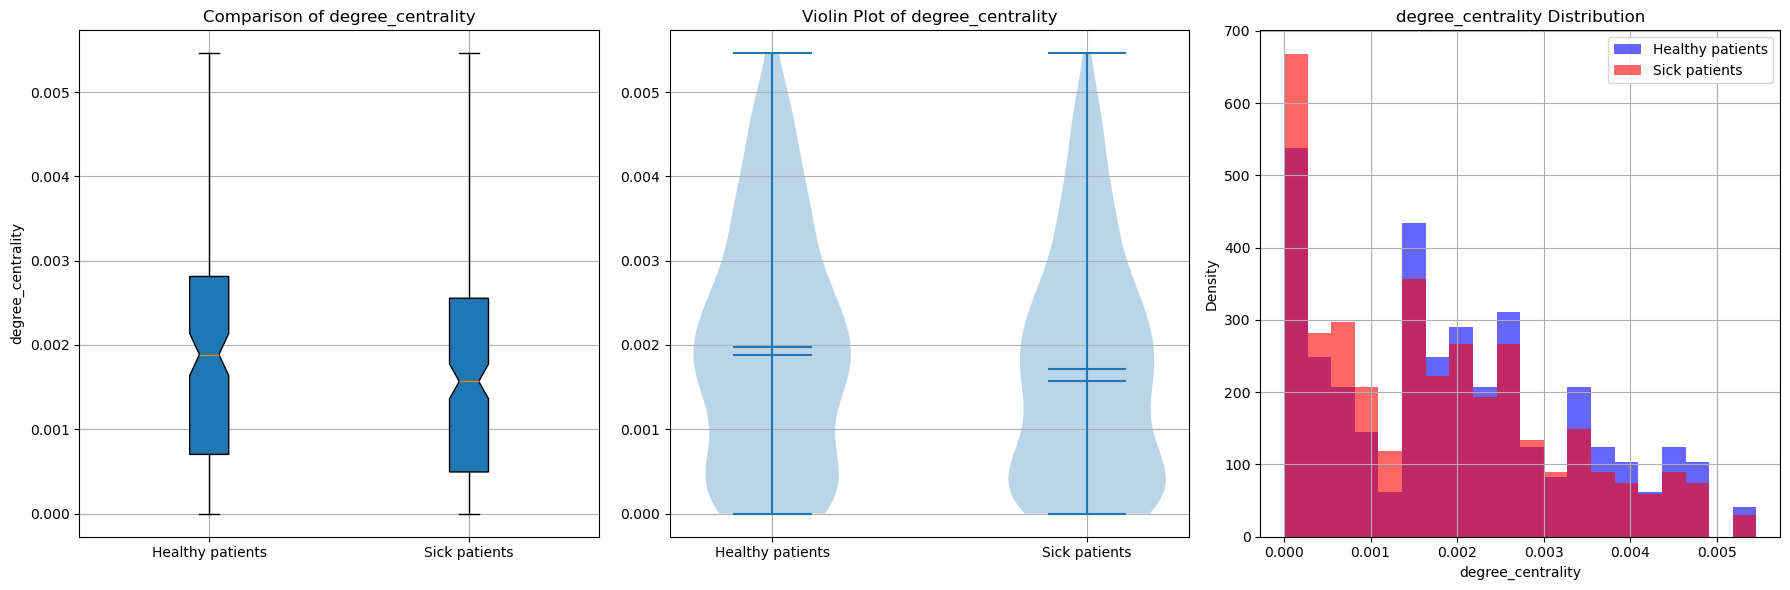

Healthy patients betweenness_centrality - Mean: 0.0003141631944044758 Median: 8.490621643670219e-08
Sick patients betweenness_centrality - Mean: 0.00045852256268008514 Median: 9.267383664247245e-08
Mann-Whitney U Test p-value: 0.6497633074751817


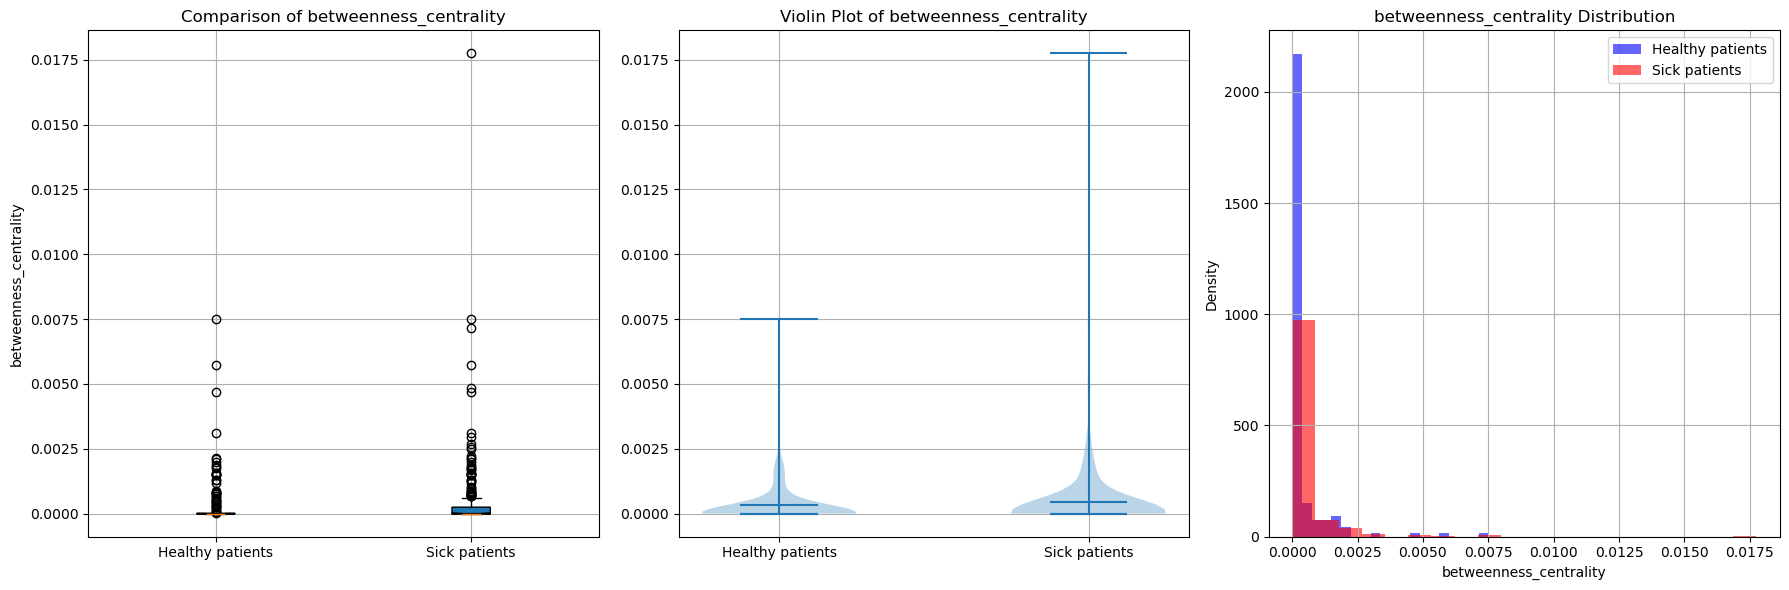

Healthy patients closeness_centrality - Mean: 0.009557339871368798 Median: 0.0032802781506909
Sick patients closeness_centrality - Mean: 0.009468989645657327 Median: 0.0032884658419724
Mann-Whitney U Test p-value: 0.4655761650420554


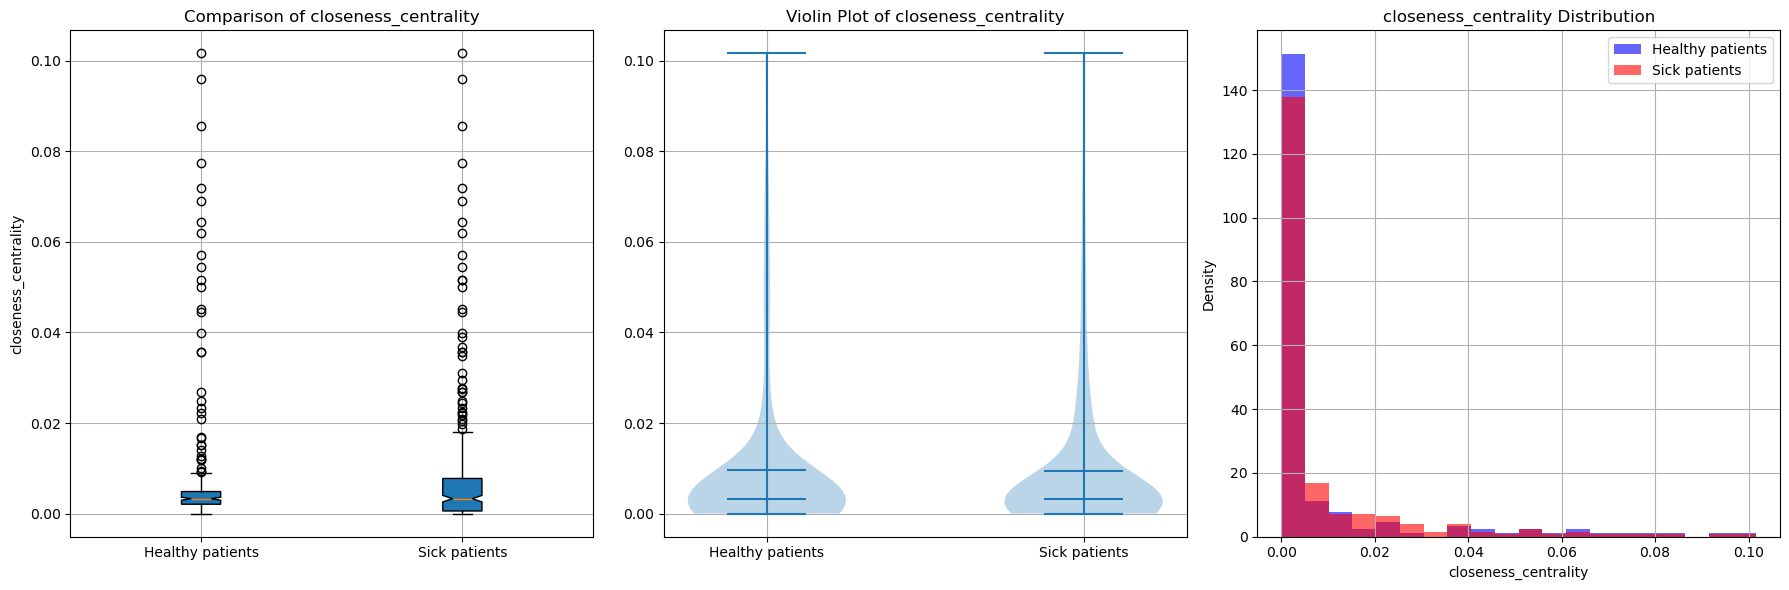

Healthy patients eigenvector_centrality - Mean: 5.780078816168187e-05 Median: 1.0248218006888933e-12
Sick patients eigenvector_centrality - Mean: 4.141999841538502e-05 Median: 8.271036540160314e-18
Mann-Whitney U Test p-value: 0.0009939826625919373


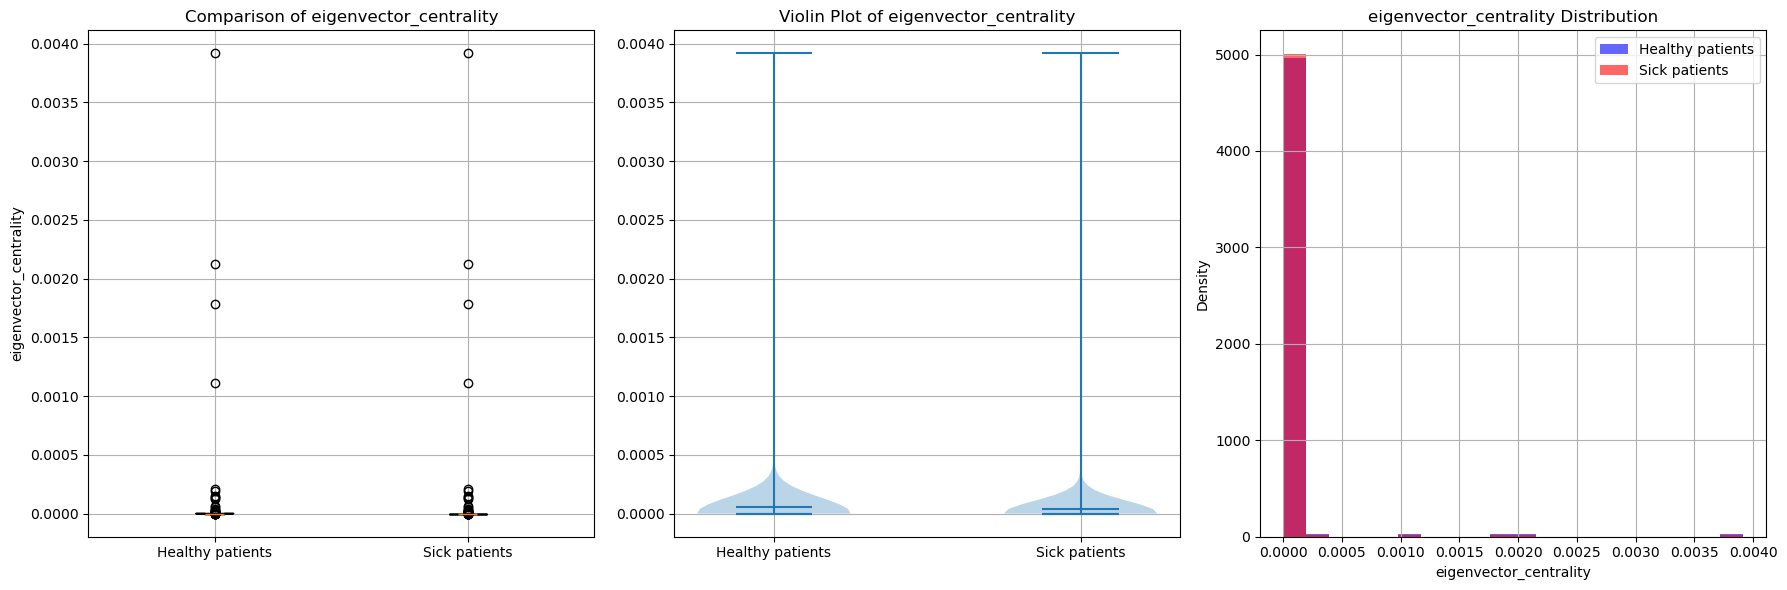

Healthy patients pagerank - Mean: 0.00015391273459015875 Median: 0.0001379688595064
Sick patients pagerank - Mean: 0.00016524193650132075 Median: 0.0001492563272574
Mann-Whitney U Test p-value: 0.8651614362508546


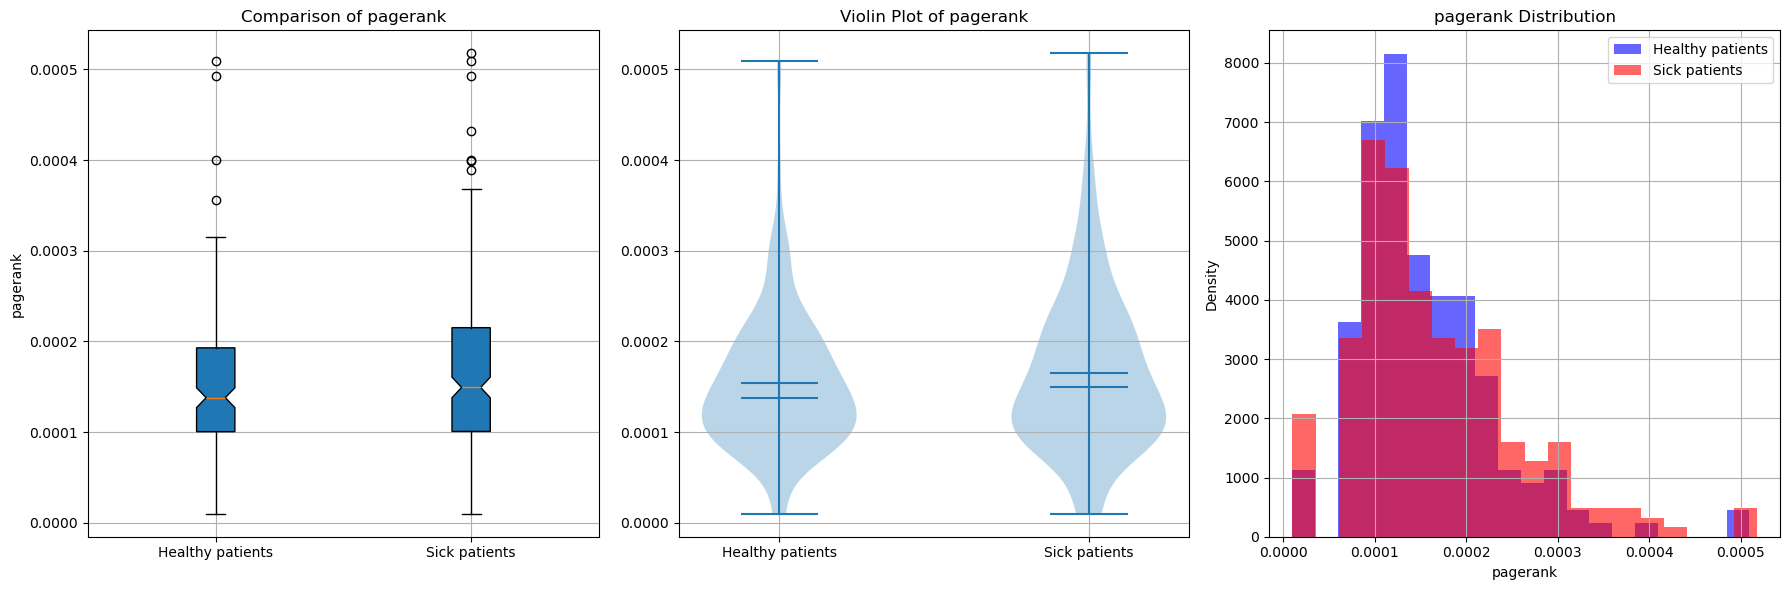

Healthy patients clustering_coefficient - Mean: 0.6695143637707249 Median: 0.832779623477298
Sick patients clustering_coefficient - Mean: 0.5980937797201066 Median: 0.7753846153846153
Mann-Whitney U Test p-value: 0.0806980584197452


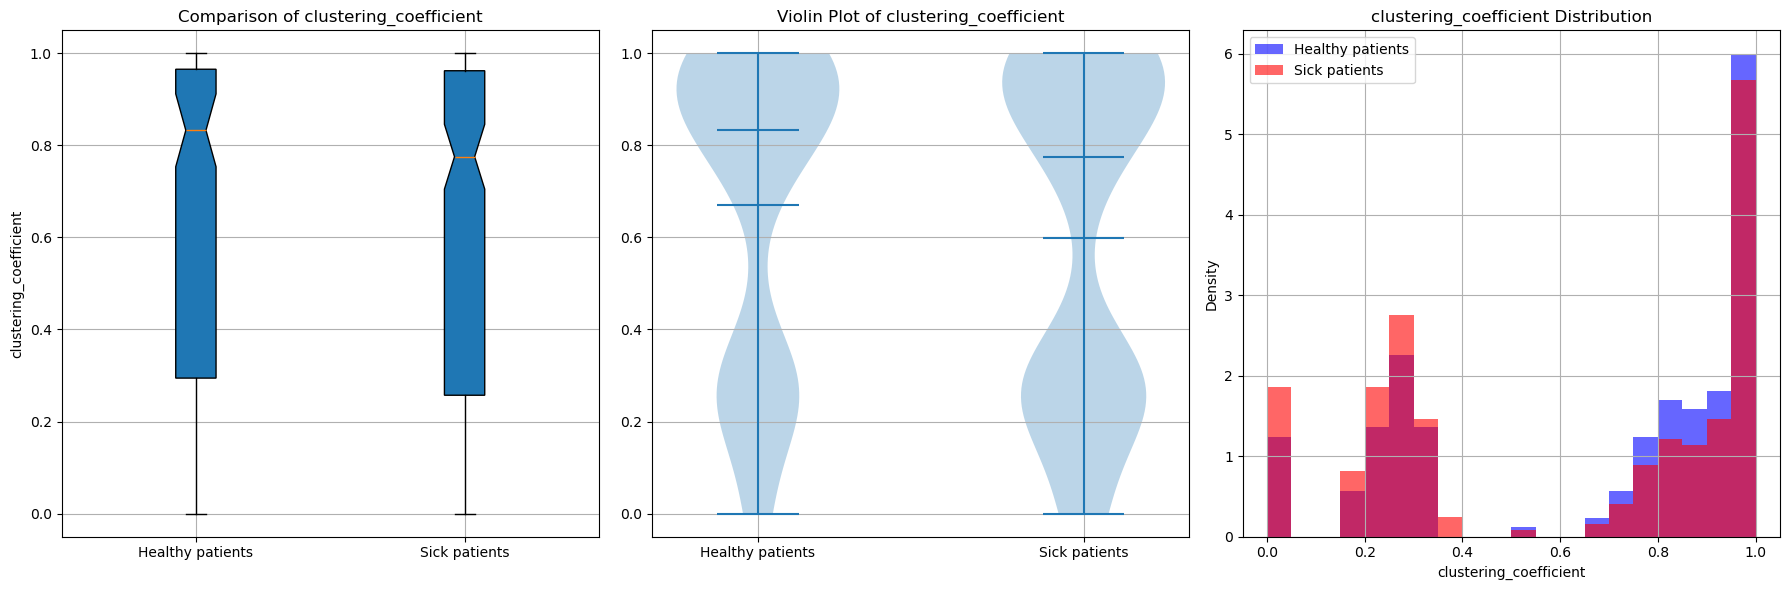

In [25]:
create_plot(selected_h_group, selected_group, centrality_stat='degree_centrality',selected_str="Healthy patients",other_str="Sick patients")
create_plot(selected_h_group, selected_group, centrality_stat='betweenness_centrality',selected_str="Healthy patients",other_str="Sick patients")
create_plot(selected_h_group, selected_group, centrality_stat='closeness_centrality',selected_str="Healthy patients",other_str="Sick patients")
create_plot(selected_h_group, selected_group, centrality_stat='eigenvector_centrality',selected_str="Healthy patients",other_str="Sick patients")
create_plot(selected_h_group, selected_group, centrality_stat='pagerank',selected_str="Healthy patients",other_str="Sick patients")
create_plot(selected_h_group, selected_group, centrality_stat='clustering_coefficient',selected_str="Healthy patients",other_str="Sick patients")

### Feature Selection

In [3]:
import networkx as nx
import pandas as pd
from collections import defaultdict

In [2]:
# Define the TCR sequences of interest (you can also leave this empty if you want all sequences)
selected_tcrs = []

# Initialize a dictionary to store cumulative centrality scores for each sequence
# cumulative_centrality = defaultdict(float) ## Sends a new dict when calling for agg function

In [3]:
def centrality_func(graph, centrality_algorithm):
        """
    Function to compute centrality values based on the selected algorithm.
    Args:
        graph (nx.Graph): The networkx graph.
        centrality_algorithm (str): The centrality algorithm to use (e.g., 'degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank', 'clustering')
    Returns:
        dict: A dictionary of centrality values for nodes in the graph.
    """
        if centrality_algorithm == 'degree':
            print("Computing Degree Centrality...")
            centrality_values = nx.degree_centrality(graph)

        elif centrality_algorithm == 'betweenness':
            print("Computing Betweenness Centrality (approximation)...")
            centrality_values = nx.betweenness_centrality(graph, k=1000)  # Approximation with 1000 random nodes

        elif centrality_algorithm == 'closeness':
            print("Computing Closeness Centrality...")
            centrality_values = nx.closeness_centrality(graph)

        elif centrality_algorithm == 'eigenvector':
            print("Computing Eigenvector Centrality...")
            try:
                # Try with initial parameters
                centrality_values = nx.eigenvector_centrality(graph, max_iter=500, tol=1e-5)
            except nx.PowerIterationFailedConvergence:
                print("Eigenvector centrality failed to converge with default settings, retrying with looser tolerance.")
                try:
                    # Retry with looser tolerance
                    centrality_values = nx.eigenvector_centrality(graph, max_iter=300, tol=1e-2)
                    print("Eigenvector centrality approximated with higher tolerance.")
                except nx.PowerIterationFailedConvergence:
                    # If it still fails, fallback to an empty result or handle it differently
                    centrality_values = {}
                    print("Eigenvector centrality could not be approximated for this graph.")

        elif centrality_algorithm == 'pagerank':
            print("Computing PageRank...")
            centrality_values = nx.pagerank(graph, max_iter=500, tol=1e-6)

        elif centrality_algorithm == 'clustering':
            print("Computing Clustering Coefficient...")
            centrality_values = nx.clustering(graph)

        else:
            raise ValueError(f"Centrality algorithm '{centrality_algorithm}' is not recognized.")

        return centrality_values


# Function to calculate the cumulative centrality across all graphs
def aggregate_centrality(graphs, centrality_algorithm, cumulative_centrality):
    # Iterate over all graphs
    for graph, graph_name in graphs:
        # Calculate centrality for all nodes in the graph
        centrality_values = centrality_func(graph, centrality_algorithm)

        # Accumulate centrality values for each node across all graphs
        for node, centrality_score in centrality_values.items():
            cumulative_centrality[node] += centrality_score
    return cumulative_centrality

# Example: Feature Engineering using the top 10 sequences
def feature_engineer_top_sequences(graphs, top_sequences):
    feature_matrix = []

    for graph, graph_name in graphs:
        # Create a binary feature vector: 1 if the top sequence is in the graph, 0 otherwise
        feature_vector = [1 if node in graph.nodes else 0 for node in top_sequences]

        # Append to the feature matrix with the graph name
        feature_matrix.append([graph_name] + feature_vector)

    # Create a DataFrame for easier handling
    columns = ['graph_name'] + [f"Top_{i+1}" for i in range(len(top_sequences))]
    feature_df = pd.DataFrame(feature_matrix, columns=columns)

    return feature_df

In [3]:
all_graphs = load_graphs_from_dir('/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc_new')

In [9]:
cumulative_pagerank_dict = aggregate_centrality(graphs=all_graphs, centrality_algorithm='pagerank', cumulative_centrality=defaultdict(float))

# Convert the cumulative centrality dictionary to a sorted list of sequences by importance
sorted_sequences = sorted(cumulative_pagerank_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 sequences with the highest cumulative centrality scores
top_10_sequences = [seq for seq, score in sorted_sequences[:50]]

# # Print the top 10 sequences
# print(f"Top 10 most important sequences based on {centrality_func.__name__}:")
# print(top_10_sequences)

Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing PageRank...
Computing 

In [10]:
# Create a feature matrix using the top 10 sequences
feature_df = feature_engineer_top_sequences(all_graphs, top_10_sequences)

In [11]:
# Display the feature matrix
print(feature_df.head(10))

     graph_name  Top_1  Top_2  Top_3  Top_4  Top_5  Top_6  Top_7  Top_8  \
0      3_A_B_OC      1      1      1      1      1      1      1      0   
1    7_nd_A_B_H      1      1      1      1      1      1      0      1   
2      38_A_B_H      0      0      0      0      1      1      0      0   
3   14_nd_A_B_H      1      1      1      1      1      0      1      0   
4     32_A_B_OC      1      1      1      1      1      0      1      0   
5      1_A_B_OC      0      1      1      1      1      0      1      0   
6  13_nd_A_B_OC      1      1      1      1      0      1      0      1   
7  10_nd_A_B_OC      1      1      1      1      1      0      0      1   
8    7_nh_A_B_H      1      1      0      1      1      1      1      1   
9      40_A_B_H      0      1      1      0      1      1      1      0   

   Top_9  ...  Top_41  Top_42  Top_43  Top_44  Top_45  Top_46  Top_47  Top_48  \
0      1  ...       0       0       0       0       0       0       1       0   
1      0  ..

In [12]:
feature_df.to_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality/pagerank_top50.csv")

In [4]:
import networkx as nx
import pandas as pd
from collections import defaultdict

# Centrality functions to use
centrality_functions = {
    'degree': nx.degree_centrality,
    # 'betweenness': lambda graph: nx.betweenness_centrality(graph, k=100),  # Using approximation for large graphs
    'closeness': nx.closeness_centrality,
    'eigenvector': lambda graph: nx.eigenvector_centrality(graph, max_iter=500, tol=1e-5),
    'pagerank': lambda graph: nx.pagerank(graph, max_iter=500, tol=1e-6),
    'clustering': nx.clustering
}

# Step 1: Function to aggregate the top 10 TCRs across all graphs for each centrality measure
def aggregate_top_tcrs(graphs, centrality_func, top_n=10):
    cumulative_centrality = defaultdict(float)

    # Iterate through all graphs to compute and aggregate centrality
    for graph, graph_name in graphs:
        centrality_values = centrality_func(graph)
        
        # Accumulate centrality values for each node across all graphs
        for node, centrality_score in centrality_values.items():
            cumulative_centrality[node] += centrality_score

    # Sort by cumulative centrality values and return the top N nodes
    sorted_sequences = sorted(cumulative_centrality.items(), key=lambda x: x[1], reverse=True)
    top_tcrs = [seq for seq, _ in sorted_sequences[:top_n]]

    return top_tcrs

# Step 2: Get top 10 TCRs for each centrality measure
top_tcrs_by_centrality = {}

for centrality_name, centrality_func in centrality_functions.items():
    print(f"Computing top 10 TCRs for {centrality_name}...")
    top_tcrs_by_centrality[centrality_name] = aggregate_top_tcrs(all_graphs, centrality_func, top_n=10)

# Step 3: Create a feature DataFrame
def create_feature_df(graphs, top_tcrs_by_centrality):
    feature_matrix = []

    for graph, graph_name in graphs:
        # Initialize feature vector with graph name
        feature_vector = [graph_name]
        
        # Iterate through each centrality measure
        for centrality_name, top_tcrs in top_tcrs_by_centrality.items():
            # Create binary feature for presence of each top TCR in the graph
            for tcr in top_tcrs:
                feature_vector.append(1 if tcr in graph.nodes else 0)

        # Append the feature vector to the feature matrix
        feature_matrix.append(feature_vector)

    # Create column names
    columns = ['graph_name']
    for centrality_name in top_tcrs_by_centrality:
        columns += [f"{centrality_name}_top_{i+1}" for i in range(10)]

    # Create and return the DataFrame
    feature_df = pd.DataFrame(feature_matrix, columns=columns)
    return feature_df

# Step 4: Generate the feature DataFrame
all_feature_df = create_feature_df(all_graphs, top_tcrs_by_centrality)

# Display the feature DataFrame
print(all_feature_df.head(10))


Computing top 10 TCRs for degree...
Computing top 10 TCRs for closeness...
Computing top 10 TCRs for eigenvector...
Computing top 10 TCRs for pagerank...
Computing top 10 TCRs for clustering...


NameError: name 'feature_df' is not defined

In [5]:
all_feature_df.to_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality/all_centrality_top10.csv")

### Ploting

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [28]:
# Randomly select 3 graphs from the list
random_graphs = random.sample(graphs, 3)

# Define colors for the selected TCRs
tcr_colors = {
    'CAVRDSNYQLIW': 'red',
    'CVVSDRGSTLGRLYF': 'green',
    'CAVLDSNYQLIW': 'blue',
    'CASSLGETQYF': 'purple'
}

working on graph: 10_A_B_OC


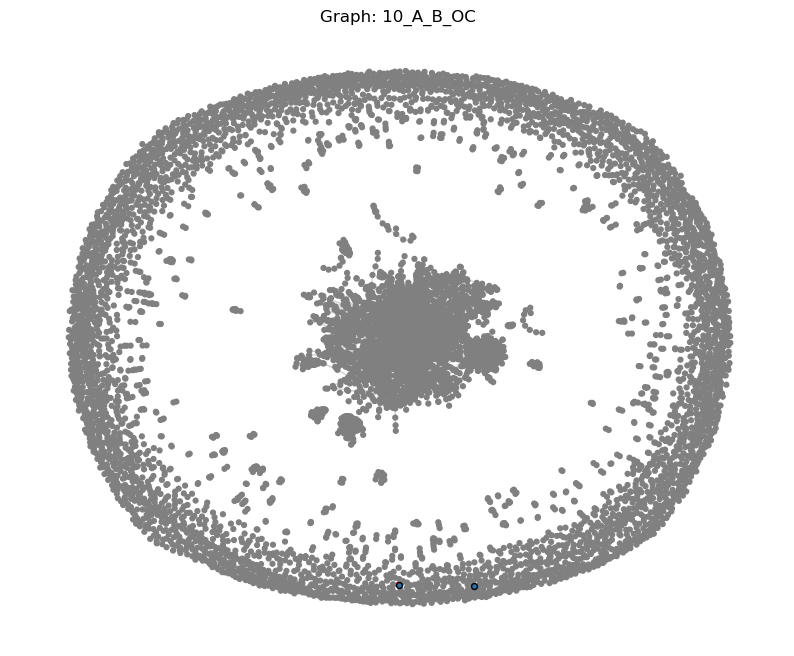

working on graph: 24_nd_A_B_H


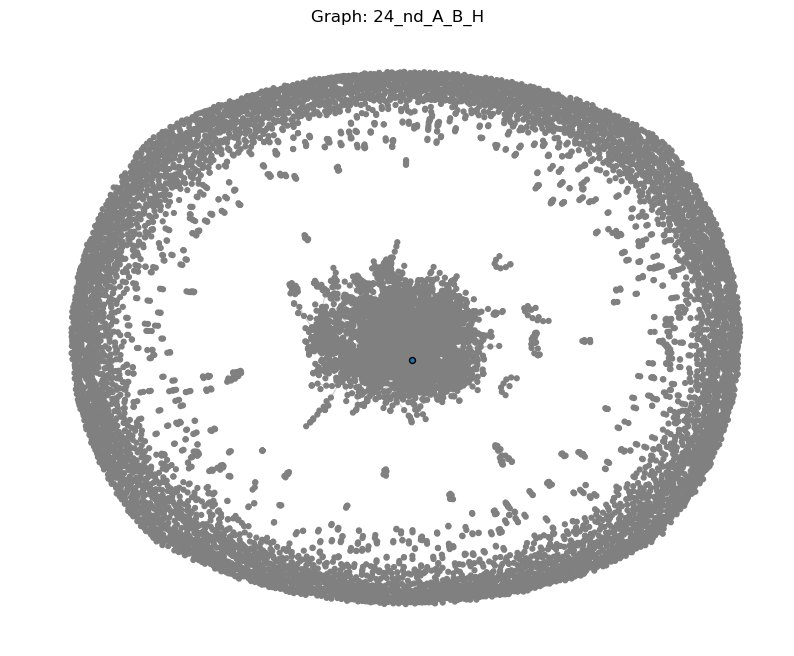

working on graph: 16_A_B_H


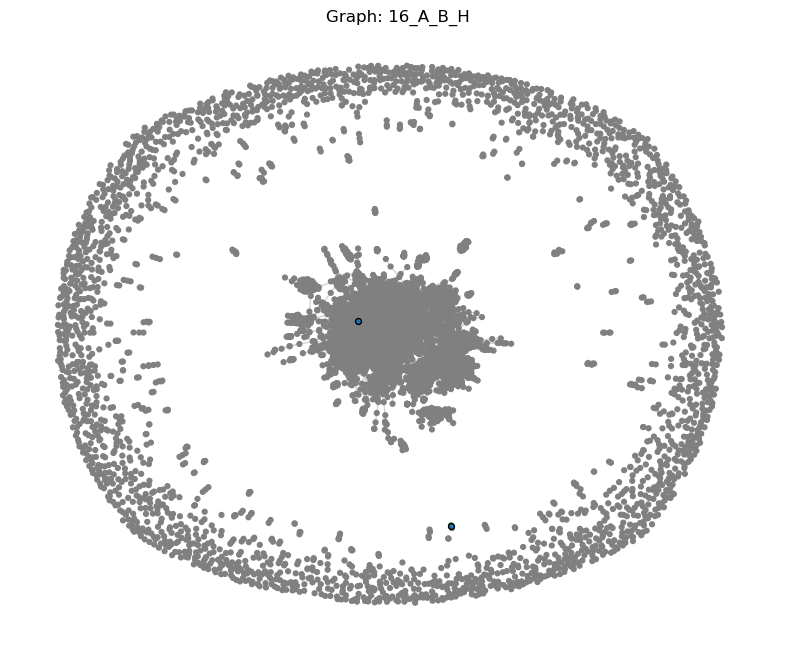

In [31]:

# Plot each selected graph
for i, (graph, graph_name) in enumerate(random_graphs):
    print(f"working on graph: {graph_name}")
    plt.figure(figsize=(10, 8))
    plt.title(f'Graph: {graph_name}')
    
    # Assign colors to nodes based on whether they are selected TCRs or not
    node_colors = []
    for node in graph.nodes:
        if node in selected_tcrs:
            node_colors.append(tcr_colors[node])  # Use the specific color for the selected TCR
        else:
            node_colors.append('gray')  # Default color for other nodes
    
    # Draw the graph with the node colors
    pos = nx.spring_layout(graph, seed=42)  # Layout for the graph, can be adjusted for better visuals
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=12, font_size=8, edge_color='lightgray')
    
    # Highlight the selected TCRs with larger sizes
    nx.draw_networkx_nodes(graph, pos, nodelist=[node for node in selected_tcrs if node in graph.nodes], node_size=18, edgecolors='black') # ensures that only nodes that are present in the graph are drawn.
    
    plt.show()

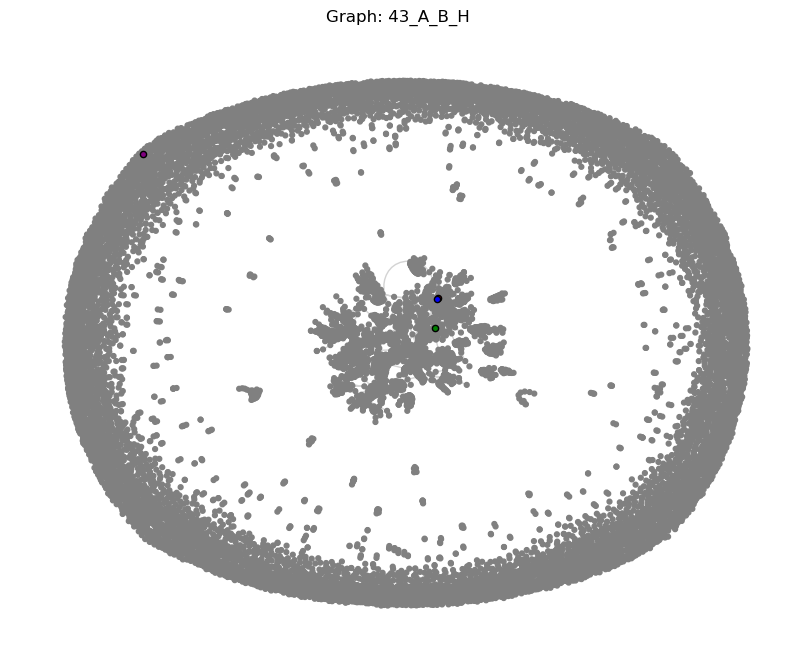

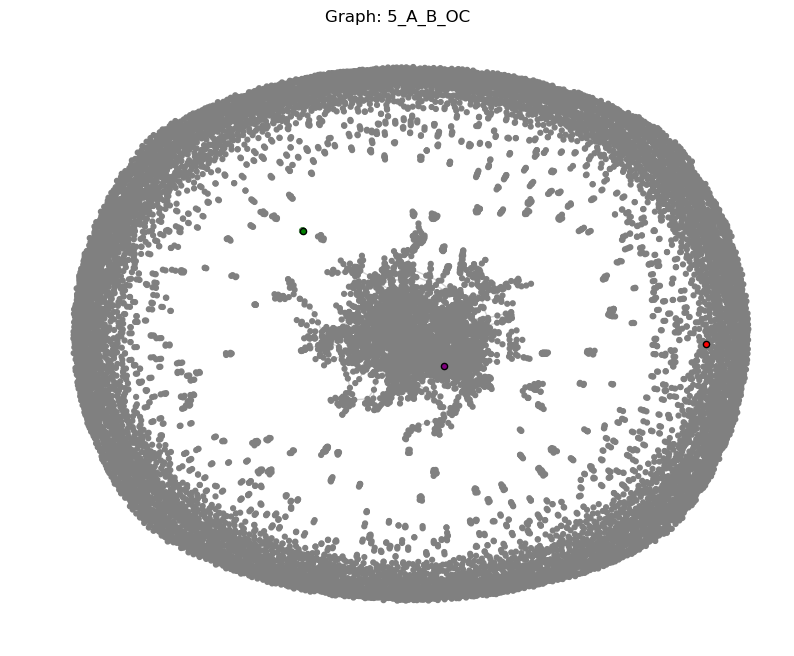

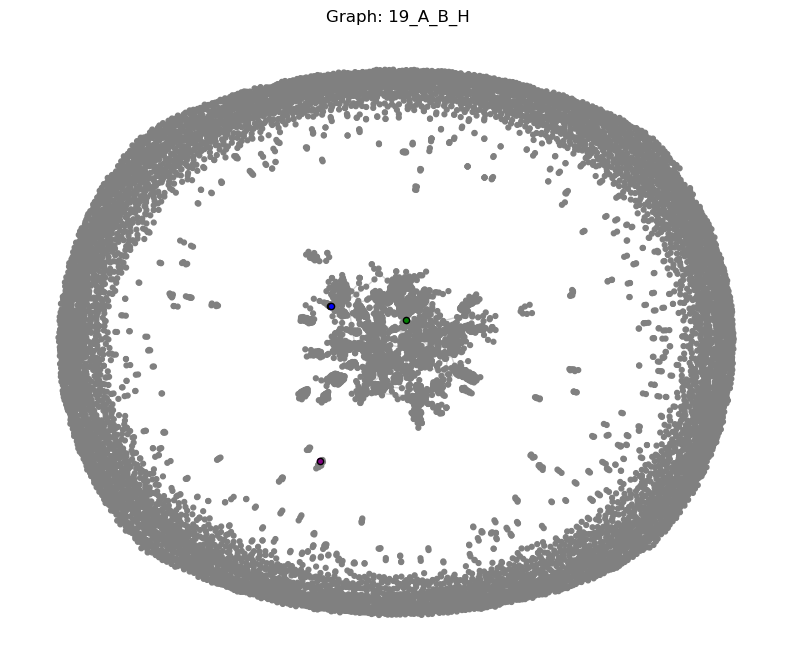

In [33]:
# List of graph names you want to fetch
target_graph_names = ['43_A_B_H', '5_A_B_OC', '19_A_B_H']

# List to store the fetched graphs as tuples
selected_graphs = []

# Iterate over the graphs and fetch the ones with the specified names
for graph, graph_name in graphs:
    if graph_name in target_graph_names:
        selected_graphs.append((graph, graph_name))

# Plot each selected graph
for i, (graph, graph_name) in enumerate(selected_graphs):
    # Generate positions for all nodes using a layout
    pos = nx.spring_layout(graph, seed=42)

    # Set default color and size for nodes
    default_color = 'gray'
    node_colors = []
    node_sizes = []

    # Assign colors and sizes based on whether nodes are selected TCRs or not
    for node in graph.nodes:
        if node in tcr_colors:
            node_colors.append(tcr_colors[node])  # Assign specific color for the TCR
            node_sizes.append(20)  # Larger size for TCR nodes
        else:
            node_colors.append(default_color)  # Default color for other nodes
            node_sizes.append(12)  # Smaller size for non-TCR nodes

    # Draw the graph with assigned node colors and sizes
    plt.figure(figsize=(10, 8))
    plt.title(f'Graph: {graph_name}')
    nx.draw(graph, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='lightgray')

    # Highlight edges for the TCR nodes, if needed
    for tcr, color in tcr_colors.items():
        if tcr in graph.nodes:
            nx.draw_networkx_nodes(graph, pos, nodelist=[tcr], node_color=color, node_size=20, edgecolors='black')
 
    plt.show()  


# Preparing data for Graphormer

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

In [2]:
def create_graph_data(G, label, graph_name):
    # # Create a NetworkX graph
    # G = nx.from_pandas_adjacency(pd.DataFrame(adjacency_matrix))
    
    # # Add node features (embeddings) to the graph
    # for i, row in df.iterrows():
    #     G.nodes[i]['x'] = row.iloc[1:].values  # Assuming embeddings start from the second column
    
     # Convert node attributes (embeddings) from numpy arrays to PyTorch tensors
    for node in G.nodes(data=True):
        if isinstance(node[1]['embedding'], np.ndarray):
            G.nodes[node[0]]['embedding'] = torch.tensor(node[1]['embedding'], dtype=torch.float32)
    
    # Convert NetworkX graph to PyTorch Geometric Data
    data = from_networkx(G)
    
    # Assign the node embeddings to data.x
    embeddings = [G.nodes[n]['embedding'] for n in G.nodes()]
    data.x = torch.stack(embeddings).float()
    
    # Add graph label
    data.y = torch.tensor([label], dtype=torch.long)

    data.name = graph_name
    
    return data

class TCRDataset(torch.utils.data.Dataset):
    def __init__(self, graph_data_list):
        self.graph_data_list = graph_data_list

    def len(self):
        return len(self.graph_data_list)

    def get(self, idx):
        return self.graph_data_list[idx]


In [3]:
import os
import pickle
import numpy as np

In [4]:
## load graphs
graph_data_list = []
directory = '/home/dsi/orrbavly/GNN_project/data/embedding_graphs'
for filename in os.listdir(directory):
    if 'fp' not in filename:
        print(f"Working on file: {filename}")
        file_path = os.path.join(directory, filename)
        # Load the graph back into a NetworkX variable
        with open(file_path, 'rb') as f:
            G_loaded = pickle.load(f)
        label = 1 if "OC" in filename else 0
        graph_data_list.append(create_graph_data(G_loaded, label, filename.rstrip(".csv")))

        

Working on file: 3_A_B_OC
Working on file: 38_A_B_H
Working on file: 32_A_B_OC
Working on file: 1_A_B_OC
Working on file: 40_A_B_H
Working on file: 37_A_B_H
Working on file: 43_A_B_H
Working on file: 14_A_B_OC
Working on file: 10_A_B_OC
Working on file: 2_A_B_H
Working on file: 3_A_B_H
Working on file: 40_A_B_OC
Working on file: 35_A_B_H
Working on file: 48_A_B_H
Working on file: 25_A_B_H
Working on file: 21_A_B_OC
Working on file: 6_A_B_H
Working on file: 46_A_B_H
Working on file: 47_A_B_H
Working on file: 41_A_B_OC


In [ ]:
torch.save(graph_data_list, "/home/dsi/orrbavly/GNN_project/data/torch_data/83_graph_data_list.pt")

## Data handling

In [17]:
from torch_geometric.data import Data, DataLoader

# Create a DataLoader for batching the graphs
train_loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from graphormer.models import GraphormerEncoder


ModuleNotFoundError: No module named 'graphormer'

# GRAN Model

In [2]:
import torch
import torch.nn as nn

In [ ]:
# Assuming your model class is defined or imported
model = YourModelClass()

# Load the pre-trained weights
model.load_state_dict(torch.load('path_to_your_model.pth'))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# DGL model

In [1]:
import torch_geometric

In [20]:
import os

# os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

In [27]:
from torch.utils.data import Dataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# load files in pt format
# data = torch.load('/home/dsi/orrbavly/GNN_project/data/torch_data/83_graph_data_list.pt')


In [24]:
# Load the NetworkX graph from the .pkl file
with open('/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc/1_A_B_H', 'rb') as f:
    G1 = pickle.load(f)  # Assuming you saved the tuple (G, label, name)


In [43]:
# load individual networkx files, saved in pickle format (with their embedding in ['embedding'])

# Define the directory containing the .pkl files
directory = '/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc'

# List to hold the converted DGL graphs
dgl_graph_list = []
# controls the patients type used in experiment
invalid_files = ["fp", "nd", 'nh']
counter = 0
# Iterate through all .pkl files in the directory
for filename in os.listdir(directory):
    if all(invalid not in filename for invalid in invalid_files):
        print(F"working on: {filename}")
        # Construct the full path to the file
        file_path = os.path.join(directory, filename)
        
        # Load the NetworkX graph from the .pkl file
        with open(file_path, 'rb') as f:
            G = pickle.load(f)  # Assuming the pkl file only contains the graph (NetworkX graph)
                
        # Determine the label from the filename (if 'OC' is in the filename, label = 1, else label = 0)
        label = 1 if 'OC' in filename else 0    

        # Convert the NetworkX graph to a DGL graph
        dgl_graph = dgl.from_networkx(G)

        # Add self-loops to the DGL graph. Help aggragate data for nodes with 0 neighboors.
        dgl_graph = dgl.add_self_loop(dgl_graph)

        # Convert the node embeddings from numpy arrays to PyTorch tensors
        embeddings = [torch.tensor(G.nodes[n]['embedding'], dtype=torch.float32) for n in G.nodes()]
        # add them ass attributes
        dgl_graph.ndata['attr'] = torch.stack(embeddings).float()
        
        # Add the graph label (squeeze to ensure it's a 1D tensor)
        dgl_graph.y = torch.tensor([label], dtype=torch.long).squeeze()
        
        # in saved pkl files, filename is the graph name.
        dgl_graph.name = filename
        
        # Append the DGL graph to the list
        dgl_graph_list.append(dgl_graph)
        counter+=1

print(f"worked on {counter} files.")


working on: 3_A_B_OC
working on: 38_A_B_H
working on: 32_A_B_OC
working on: 1_A_B_OC
working on: 40_A_B_H
working on: 37_A_B_H
working on: 43_A_B_H
working on: 14_A_B_OC
working on: 10_A_B_OC
working on: 2_A_B_H
working on: 3_A_B_H
working on: 40_A_B_OC
working on: 35_A_B_H
working on: 48_A_B_H
working on: 25_A_B_H
working on: 21_A_B_OC
working on: 6_A_B_H
working on: 46_A_B_H
working on: 47_A_B_H
working on: 41_A_B_OC
working on: 14_A_B_H
working on: 41_A_B_H
working on: 29_A_B_H
working on: 4_A_B_H
working on: 15_A_B_OC
working on: 4_A_B_OC
working on: 38_A_B_OC
working on: 12_A_B_H
working on: 2_A_B_OC
working on: 45_A_B_OC
working on: 7_A_B_OC
working on: 6_A_B_OC
working on: 9_A_B_H
working on: 5_A_B_OC
working on: 19_A_B_OC
working on: 10_A_B_H
working on: 17_A_B_H
working on: 12_A_B_OC
working on: 18_A_B_OC
working on: 16_A_B_OC
working on: 15_A_B_H
working on: 25_A_B_OC
working on: 7_A_B_H
working on: 39_A_B_OC
working on: 18_A_B_H
working on: 28_A_B_H
working on: 34_A_B_H
work

In [44]:
# Step 1: Define a custom DGL Dataset class
class CustomDGLDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        # Return a tuple (graph, label)
        graph = self.graphs[idx]
        return graph, graph.y, graph.name

In [45]:
# Step 2: Initialize the custom dataset
dgl_dataset = CustomDGLDataset(dgl_graph_list)

In [46]:
num_examples = len(dgl_dataset)
num_train = int(num_examples * 0.8)

# Create samplers for train and test sets
train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

# Create DataLoaders for the training and test sets
train_dataloader = GraphDataLoader(
    dgl_dataset, sampler=train_sampler, batch_size=5, drop_last=False
)

test_dataloader = GraphDataLoader(
    dgl_dataset, sampler=test_sampler, batch_size=5, drop_last=False
)


In [47]:
# batch has: graphs, lables, graph names. original dgl dataset only had the first variables.
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=74962, num_edges=1002212,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={}), tensor([[1],
        [0],
        [1],
        [0],
        [1]]), ('10_A_B_OC', '14_A_B_H', '32_A_B_OC', '31_A_B_H', '38_A_B_OC')]


In [48]:
batched_graph, labels, names = batch
print(
    "Number of nodes for each graph element in the batch:",
    batched_graph.batch_num_nodes(),
)
print(
    "Number of edges for each graph element in the batch:",
    batched_graph.batch_num_edges(),
)

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print("The original graphs in the minibatch:")
print(graphs)
print(names)

Number of nodes for each graph element in the batch: tensor([11689, 19075, 14875, 13515, 15808])
Number of edges for each graph element in the batch: tensor([136795, 284525, 194843, 169161, 216888])
The original graphs in the minibatch:
[Graph(num_nodes=11689, num_edges=136795,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=19075, num_edges=284525,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=14875, num_edges=194843,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=13515, num_edges=169161,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=15808, num_edges=216888,
      ndata_schemes={'attr': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={})]
('10_A_B_OC', '14_A_B_H', '32_A_B_OC', '31_A_B_H', '38_A_B_OC')


In [49]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [53]:
# Create the model with given dimensions
# Uses .squeeze() to convert the labels from shape [batch_size, 1] to [batch_size]
hidden_layer_feats = 16
num_of_classes = 2
dim_of_embedding = 768
model = GCN(dim_of_embedding, hidden_layer_feats, num_of_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30):
    print(f"epoch: {epoch + 1}")
    for batched_graph, labels, graph_names in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(pred, labels.squeeze(1))  # Squeeze along the second dimension for 1D tensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30


In [55]:
num_correct = 0
num_tests = 0
for batched_graph, labels, graphs_name in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata["attr"].float())
    # Ensure labels are 1D by using .squeeze(1)
    labels = labels.squeeze(1)  # Make sure labels are 1D
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print("Test accuracy:", num_correct / num_tests)

Test accuracy: 0.5882352941176471


## Test Dataset(proetins)

In [8]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

/home/dsi/orrbavly/.dgl/GINDataset.zip: 100%|██████████| 33.4M/33.4M [00:00<00:00, 36.7MB/s]


Extracting file to /home/dsi/orrbavly/.dgl/GINDataset


In [9]:
print("Node feature dimensionality:", dataset.dim_nfeats)
print("Number of graph categories:", dataset.gclasses)


from dgl.dataloading import GraphDataLoader

Node feature dimensionality: 3
Number of graph categories: 2


In [10]:
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False
)

In [15]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=226, num_edges=1034,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor([0, 0, 0, 1, 0])]


In [16]:
batched_graph, labels = batch
print(
    "Number of nodes for each graph element in the batch:",
    batched_graph.batch_num_nodes(),
)
print(
    "Number of edges for each graph element in the batch:",
    batched_graph.batch_num_edges(),
)

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print("The original graphs in the minibatch:")
print(graphs)

Number of nodes for each graph element in the batch: tensor([117,  30,  48,  20,  11])
Number of edges for each graph element in the batch: tensor([505, 174, 226,  76,  53])
The original graphs in the minibatch:
[Graph(num_nodes=117, num_edges=505,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=30, num_edges=174,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=48, num_edges=226,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=76,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=11, num_edges=53,
      ndata_schemes={'label': Scheme(shape=(), dt

In [17]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [18]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata["attr"].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print("Test accuracy:", num_correct / num_tests)

Test accuracy: 0.2600896860986547


## TESTING

In [ ]:
# Step 2: Convert PyTorch graphs to DGL graphs
# Function to convert a PyTorch Geometric graph to a DGL graph
def convert_to_dgl(py_g):
    # Convert to NetworkX graph first
    nx_g = to_networkx(py_g, to_undirected=True)
    
    # Create a DGL graph from NetworkX graph
    dgl_g = dgl.from_networkx(nx_g)
    
    # Set the node embeddings (stored as 'x' in PyTorch Geometric Data)
    if hasattr(py_g, 'x') and py_g.x is not None:
        dgl_g.ndata['feat'] = py_g.x
    
    # Set the graph label (stored as 'y' in PyTorch Geometric Data)
    if hasattr(py_g, 'y') and py_g.y is not None:
        dgl_g.gdata['label'] = py_g.y
    
    # Return the converted DGL graph
    return dgl_g


In [ ]:
dgl_graphs = [convert_to_dgl(py_g) for py_g in graph_list]


In [ ]:
# Step 3: Create a custom dataset
class CustomGraphDataset(Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [ ]:
graph_dataset = CustomGraphDataset(dgl_graphs)
